# TravelTide Mastery Project — Customer Segmentation for Personalized Perks

**Goal**  
Use behavioral data to segment customers and assign a **likely favorite perk based on cluster characteristics** (examples: free checked bag, free cancellation, exclusive discounts, etc).

---

**Project Workflow Overview**  

1. **Data Exploration** 🔍 — Review the aggregated user-level dataset from SQL, validate feature definitions, and understand the behavioral metrics available for analysis.  
2. **Data Preparation** 🛠️ — Clean, transform, handle skew/outliers, and scale where needed.  
3. **Segmentation Analysis** 📊 — Test clustering approaches, assess quality, and interpret results.  
4. **Cluster Profiling** 🧩 — Describe each group’s key characteristics and potential perk alignment, present insights, lock on final perk.
5. **Visual Storytelling & Wrap-U** 📈 - Plots for visual representation and later presentation stage , summary , next steps , handoff deliverables.
---

**Business Context**  
TravelTide has excelled in travel inventory and search technology, but **customer retention remains a challenge**.  
Elena’s hypothesis is that **targeted perk messaging** (e.g., “Free Checked Bag” or “No Cancellation Fees”) can increase engagement and reward program signups.  

To support this, we need to **segment users meaningfully based on behavior**, not assumptions.  


## 1.Data Exploration 🔍

In this phase, we review the **aggregated user-level dataset** produced from the SQL feature engineering process.  
Our goals are to:

- Confirm the dataset has loaded correctly and matches the intended structure.
- Understand the types and ranges of available behavioral features.
- Identify any missing values or inconsistencies that need handling before analysis.

This section includes:
- **1.1 Upload and Preview the Dataset** — Load the CSV, check dimensions, and view a sample of rows.  
- **1.2 Data Overview – Types, Nulls, and Summary Stats** — Inspect data types, missing values, and summary statistics for initial understanding.


### 1.1 Upload and Preview the Dataset

We begin by uploading the final **user-level** dataset (`TravelTideFinal.csv`), which contains all engineered behavioral features.  
This dataset is the output of a multi-step **SQL query** that aggregates session, flight, and hotel data by `user_id` and prepares it for clustering analysis.

In this step, we will:
- Upload the dataset to Colab.
- Confirm its dimensions (rows × columns).
- Preview the first few rows to verify structure and content.


In [1]:
# --- Data handling & analysis ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Notebook display ---
from IPython.display import display

# --- Machine learning utilities ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Colab-specific ---
from google.colab import files

# Upload the file from your local machine
upload = files.upload()

# Load CSV into DataFrame
df = pd.read_csv('TravelTideFinal.csv')

# Display dataset shape and preview
pd.set_option("display.max_columns", None)
print(f"✅ Data shape: {df.shape}")
df.head()


Saving TravelTideFinal.csv to TravelTideFinal.csv
✅ Data shape: (5998, 21)


,user_id,age,married,has_children,total_sessions,total_clicks,avg_session_duration_sec,total_completed_trips,booking_conversion_rate,total_checked_bags,total_distance_km,money_spent_flight,money_spent_hotel,hotel_loyalty_score,avg_days_booking_to_trip,avg_trip_duration_days,flight_only_rate,hotel_only_rate,both_booked_rate,discount_usage_rate,cancellation_per_booking_rate
0,23557,64,1,0,8,82,77,2,0.25,0,0,0.0,3670.5,0.5,13.0,10.0,0.0,1.0,0.0,0.5,0.0
1,94883,50,1,0,8,73,68,2,0.25,1,2907,2974.5,230.0,0.5,8.0,2.0,0.0,0.0,1.0,0.0,0.0
2,101486,50,1,1,8,131,122,2,0.25,0,965,379.8,2452.0,0.5,8.0,5.0,0.0,0.5,0.5,0.0,0.0
3,101961,42,1,0,8,126,118,5,0.63,2,6608,2475.4,2798.0,0.2,7.0,5.0,0.0,0.0,1.0,0.2,0.0
4,106907,44,1,1,8,240,759,0,0.13,0,0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0,1.0


#### 📎 TravelTide — Feature Dictionary & Rationale (SQL Output)

**Scope.** This document describes the user-level features produced by the final SQL extraction used to create `TravelTideFinal.csv`.  
**Cohort.** Sessions with `session_start > '2023-01-04'`; users with **> 7 sessions** are retained.  
**Trip states.** For any `trip_id`, exactly one of:  
0) no booking occurred, 1) booking occurred & trip completed, 2) booking occurred & trip cancelled.  
**Level.** One row per `user_id`.

> Note: Columns like `log_*`, `cluster`, `cluster_name`, `perk`, and `trip_duration_type` are **added later in the notebook** and are not part of the SQL export.

---

## Identifiers & Demographics
- **user_id**  
  **Definition:** Unique user identifier.  
  **Why:** Join key across tables; basis for user-level aggregation.

- **age**  
  **Definition:** `DATE_PART('year', AGE(session_start, birthdate))` averaged over the user’s sessions, then rounded.  
  **Why:** Age bands can correlate with travel cadence, trip length, and spend patterns.  
  **Notes:** Computed relative to session times; rounded to reduce noise.

- **married**, **has_children**  
  **Definition:** Binary demographic flags (cast to integers) aggregated with `MIN()` at user level.  
  **Why:** Household composition can influence party size, bag usage, and hotel vs. flight propensity.  
  **Notes:** `MIN()` preserves a “true if ever true” behavior given binary casting in this cohort.

---

## Engagement & Session Quality
- **total_sessions**  
  **Definition:** Count of sessions per user within cohort window.  
  **Why:** Activity volume proxy; supports normalization of other rates if needed.

- **total_clicks**  
  **Definition:** Sum of `page_clicks` across sessions.  
  **Why:** Engagement depth; higher can signal interest or friction.

- **avg_session_duration_sec**  
  **Definition:** Average of `(session_end - session_start)` in seconds, rounded.  
  **Why:** Attention proxy; very short or very long can indicate distinct behaviors (decisive vs. exploratory).

---

## Conversion & Trip Completion
- **total_completed_trips**  
  **Definition:** Count of distinct `trip_id` in `completed_trips` CTE (booked, not cancelled).  
  **Why:** Realized value; anchors monetization metrics.

- **booking_conversion_rate**  
  **Definition:** `ROUND(COUNT(DISTINCT trip_id) / COUNT(*), 2)` at user level.  
  **Why:** Session-to-trip efficiency proxy; helps separate browsers from bookers.  
  **Notes:** Session-based denominator by design.

---

## Baggage, Distance & Spend
- **total_checked_bags**  
  **Definition:** Sum of `checked_bags` for trips counted as completed.  
  **Why:** Signal for **Free Checked Bag** perk; correlates with party size and route type.

- **total_distance_km**  
  **Definition:** Sum of Haversine distance between home and destination airports over completed trips; rounded.  
  **Why:** Travel radius; helps distinguish local vs. long-haul travelers.

- **money_spent_flight**  
  **Definition:** For sessions with `flight_booked = TRUE` & `cancellation = FALSE`:  
  `base_fare_usd * seats * (2 if return_flight_booked else 1) * (1 - COALESCE(flight_discount_amount, 0))`, summed.  
  **Why:** Monetization signal; indicates value of flight relationship.  
  **Notes:** Discount-adjusted; round-trip multiplier included.

- **money_spent_hotel**  
  **Definition:** For sessions with `hotel_booked = TRUE` & `cancellation = FALSE`:  
  `hotel_per_room_usd * rooms * nights * (1 - COALESCE(hotel_discount_amount, 0))`, summed, where  
  `nights = GREATEST(check_out, check_in) - LEAST(check_out, check_in)`.  
  **Why:** Hotel monetization; supports perks like **Free Hotel Meal** or **Free Night**.

- **hotel_loyalty_score**  
  **Definition:** `1 / (# of distinct hotel brands)` booked on completed trips (0 if none), rounded to 3 decimals.  
  **Why:** Brand concentration proxy; higher = more loyal to a brand (candidate for hotel-centric perks).

---

## Timing & Duration
- **avg_days_booking_to_trip**  
  **Definition:** Average days from booking session end to either flight departure or hotel check-in (completed trips only), rounded.  
  **Why:** Lead-time behavior; useful for messaging cadence and cancellation sensitivity signals.

- **avg_trip_duration_days**  
  **Definition:** Average of `(return_time - departure_time)` for flights, else `(check_out - check_in)` for hotel-only trips (completed trips only), rounded.  
  **Why:** Trip length profile; separates short breaks from longer stays.

---

## Product Mix & Incentives
- **flight_only_rate**  
  **Definition:** Share of distinct trips that are **flight only** (booked flight, no hotel, not cancelled), rounded to 2 decimals.  
  **Why:** Product preference indicator; informs perk relevance.

- **hotel_only_rate**  
  **Definition:** Share of distinct trips that are **hotel only** (booked hotel, no flight, not cancelled), rounded to 2 decimals.  
  **Why:** Hotel inclination; supports hotel-first messaging and perks.

- **both_booked_rate**  
  **Definition:** Share of distinct trips with **both flight and hotel** booked (not cancelled), rounded to 2 decimals.  
  **Why:** Bundling propensity; supports **Free Night with Flight** positioning.

- **discount_usage_rate**  
  **Definition:** Share of distinct trips where a **discount was present and a booking occurred** (not cancelled), rounded to 2 decimals.  
  **Why:** Price sensitivity proxy; candidates for **Exclusive Discounts** messaging.

- **cancellation_per_booking_rate**  
  **Definition:** Share of distinct trips with **cancellation** events, rounded to 2 decimals.  
  **Why:** Volatility/flex preference; candidates for **Free Cancellation** emphasis.

---

## Notebook-Added (Not from SQL)
- **log_money_spent_flight**, **log_money_spent_hotel**, **log_avg_days_booking_to_trip**  
  **Why:** Skew reduction and interpretability checks during modeling.
- **cluster**, **cluster_name**, **perk**, **trip_duration_type**  
  **Why:** Final segmentation outputs and presentation helpers.

---

## Provenance & Assumptions
- Cohort filters and session constraints applied as in the SQL.  
- `completed_trips` reflects booked-and-not-cancelled logic; aligned with the three trip states.  
- Rounding is applied to several metrics for readability; raw values were used for modeling where appropriate.

## Known Data Issues & Workarounds (Important)

We encountered a few quirks in the raw tables. Below are the issues and exactly how we handled them so downstream users interpret features correctly.

### 1) Negative `nights` in hotels
- **Issue:** Some rows had `nights` ≤ 0 due to inconsistent `check_in_time` / `check_out_time`.
- **Fix used in SQL:** Compute nights as a **row-wise max–min** of the timestamps:  
  `GREATEST(check_out_time::date, check_in_time::date) - LEAST(check_out_time::date, check_in_time::date)`  
  (This is the Postgres equivalent of per-row MAX/MIN across columns.)
- **Impact:** Eliminates negative durations and preserves valid long stays. All hotel spend and trip-duration metrics derived from this are now non-negative and consistent.

### 2) Cancellation sessions flip core flags to TRUE
- **Issue:** Any **cancellation session** had `flight_discount`, `hotel_discount`, `flight_booked`, and `hotel_booked` all set to **TRUE**, regardless of the actual booking session state.
- **Workarounds we adopted:**
  - **Do not rely on raw session flags** from cancellation sessions for conversions/discount usage.
  - Use the **`completed_trips` CTE** wherever we need **finalized behavior** (booked & not cancelled).
  - For **discount usage** and related rates, count only non-cancellation cases; cancellation sessions are explicitly excluded in the logic.
- **Interpretation tip:** Rates that summarize *finalized bookings* are safe. Where we intentionally use session-level signals (see #4 below), treat them as **intent** rather than confirmed outcomes.

### 3) `hotel_name` contains brand + city in one field
- **Issue:** `hotel_name` encodes both brand and city (e.g., `"Brand - City"`).
- **Approach:** Split on `' - '` and take the **brand** portion for loyalty measures:  
  `SPLIT_PART(hotel_name, ' - ', 1)`  
- **Assumption:** Stable delimiter pattern `"brand - city"`. If the delimiter is missing, the full string acts as the brand token.
- **Why:** Loyalty logic should reflect **brand concentration**, not city variety.

### 4) Why some features don’t use `completed_trips`
- **Intent vs. Outcome:** Not all aggregates flow through `completed_trips` on purpose. For example, session-based engagement or conversion-style ratios using session counts can be informative about **initial intent**, funnel behavior, or friction *before* a booking is finalized.
- **Balance with cancellations:** To keep this honest, we also surface **`cancellation_per_booking_rate`** so that highly intent-driven users who later cancel are contextualized. In short:
  - **Outcome-focused metrics** → use `completed_trips` to avoid contamination.
  - **Intent/surface behavior metrics** → may be session-based by design, then **interpreted together** with cancellation rate.

---

### Practical Implications for Reuse
- When building **KPI dashboards** or **new models** on top of this dataset:
  - Prefer the **trip-level** (completed) metrics for performance & monetization views.
  - Use **session-based** features for diagnosing funnel behavior/intent and always read them alongside **cancellation_per_booking_rate**.
  - Treat the split of `hotel_name` as a **brand proxy**, not a perfect taxonomy.

These guardrails reflect the data realities we found and explain why the final features behave sensibly in clustering and perk assignment.

*This dictionary accompanies the final SQL query and `TravelTideFinal.csv` and is intended for stakeholders and technical peers to understand each feature’s logic and purpose.*


### 1.2 Data Overview – Types, Nulls, and Summary Stats

Now that the dataset is loaded, we will:

- Check the data types for each column.
- Identify missing values.
- Generate descriptive statistics to understand data distribution.

This will help assess data quality before proceeding to outlier detection and scaling.


In [2]:
# Check data types
print("Column Types:")
print(df.dtypes)

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Basic descriptive statistics
print("\nSummary Statistics:")
df.describe(include='all').T  # Transposed for better readability


Column Types:
user_id                            int64
age                                int64
married                            int64
has_children                       int64
total_sessions                     int64
total_clicks                       int64
avg_session_duration_sec           int64
total_completed_trips              int64
booking_conversion_rate          float64
total_checked_bags                 int64
total_distance_km                  int64
money_spent_flight               float64
money_spent_hotel                float64
hotel_loyalty_score              float64
avg_days_booking_to_trip         float64
avg_trip_duration_days           float64
flight_only_rate                 float64
hotel_only_rate                  float64
both_booked_rate                 float64
discount_usage_rate              float64
cancellation_per_booking_rate    float64
dtype: object

Missing Values per Column:
user_id                            0
age                                0
married  

,count,mean,std,min,25%,50%,75%,max
user_id,5998.0,545440.695565,64924.749760,23557.0,517152.000,540542.000,574146.000,844489.0
age,5998.0,40.486829,12.047572,16.0,33.000,41.000,48.000,87.0
married,5998.0,0.440480,0.496486,0.0,0.000,0.000,1.000,1.0
has_children,5998.0,0.326442,0.468950,0.0,0.000,0.000,1.000,1.0
total_sessions,5998.0,8.204568,0.460911,8.0,8.000,8.000,8.000,12.0
total_clicks,5998.0,144.308436,72.330165,33.0,102.000,127.000,161.000,873.0
avg_session_duration_sec,5998.0,187.108703,241.056274,32.0,93.000,116.000,147.000,2138.0
total_completed_trips,5998.0,2.582361,1.533290,0.0,1.000,3.000,4.000,8.0
booking_conversion_rate,5998.0,0.329340,0.186029,0.0,0.220,0.330,0.500,1.0
total_checked_bags,5998.0,1.252918,1.264919,0.0,0.000,1.000,2.000,9.0


## 2.Data Preparation 🛠️

Before applying any clustering algorithms, the dataset must be prepared to ensure fair comparisons between users and meaningful results.

In this phase, we will:
- Address skewed feature distributions through transformations.
- Detect and, if needed, handle outliers.
- Scale features to remove the impact of differing units and ranges.

These steps ensure that no single feature dominates the clustering due to its scale or extreme values, and that patterns are driven by true behavioral differences rather than raw magnitude.

**Guiding principle:** We evaluate transformations pragmatically and **only apply them when they improve clustering quality or stability**.


### 2.1 Visualize Feature Distributions & Detect Outliers

Before clustering, we need to examine how numerical features are distributed.

This step helps us:
- Detect outliers that could skew clustering
- Understand feature spread and central tendencies
- Identify variables that may need scaling or transformation

We'll start by plotting histograms for key features, and then use boxplots to spot outliers.


Top zero-inflated features:
cancellation_per_booking_rate    0.824775
has_children                     0.673558
flight_only_rate                 0.665555
hotel_only_rate                  0.592531
married                          0.559520
discount_usage_rate              0.406135
total_checked_bags               0.341781
money_spent_flight               0.158886
total_distance_km                0.158886
money_spent_hotel                0.115372

Most positively skewed features:
money_spent_flight               25.811623
avg_days_booking_to_trip          7.477531
cancellation_per_booking_rate     4.184235
avg_session_duration_sec          3.304526
money_spent_hotel                 2.784460
total_clicks                      2.471422
avg_trip_duration_days            2.390110
total_sessions                    2.316509
flight_only_rate                  2.233340
hotel_only_rate                   1.727459


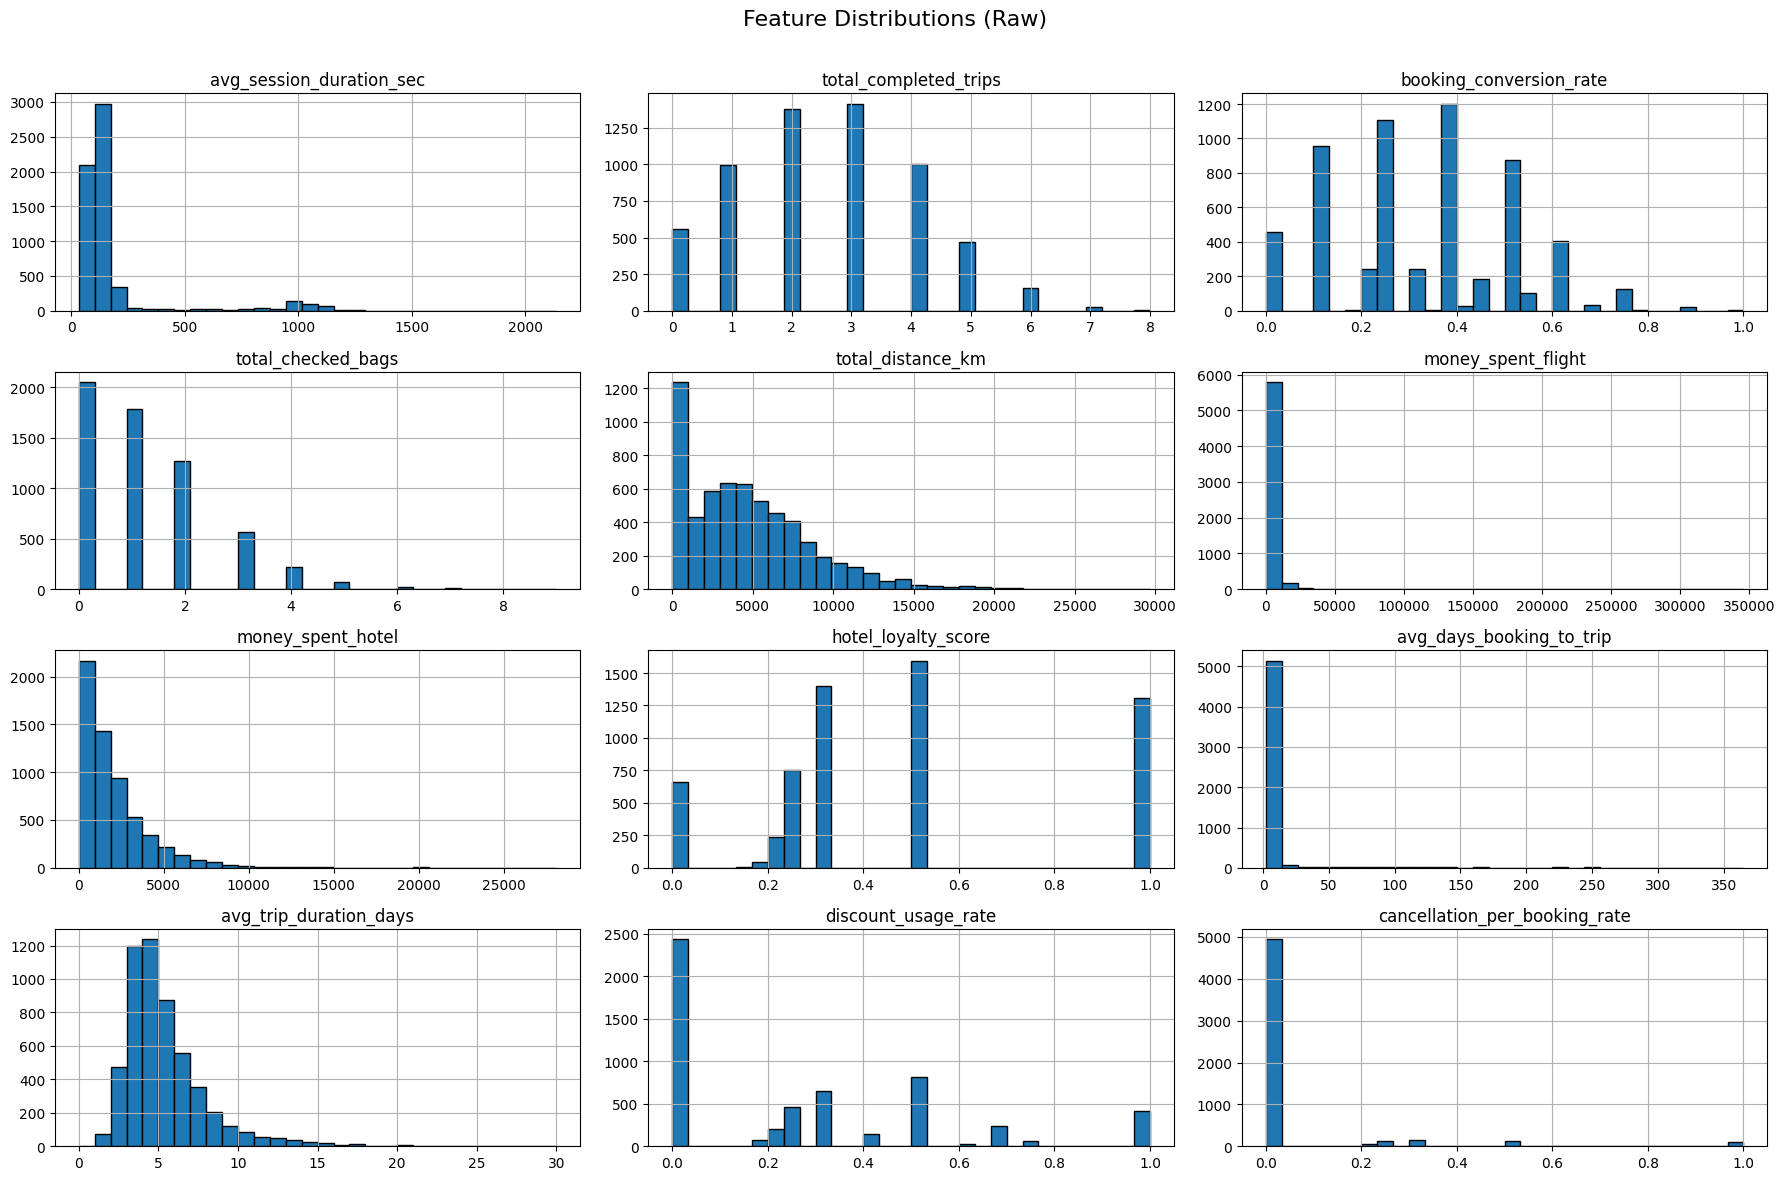

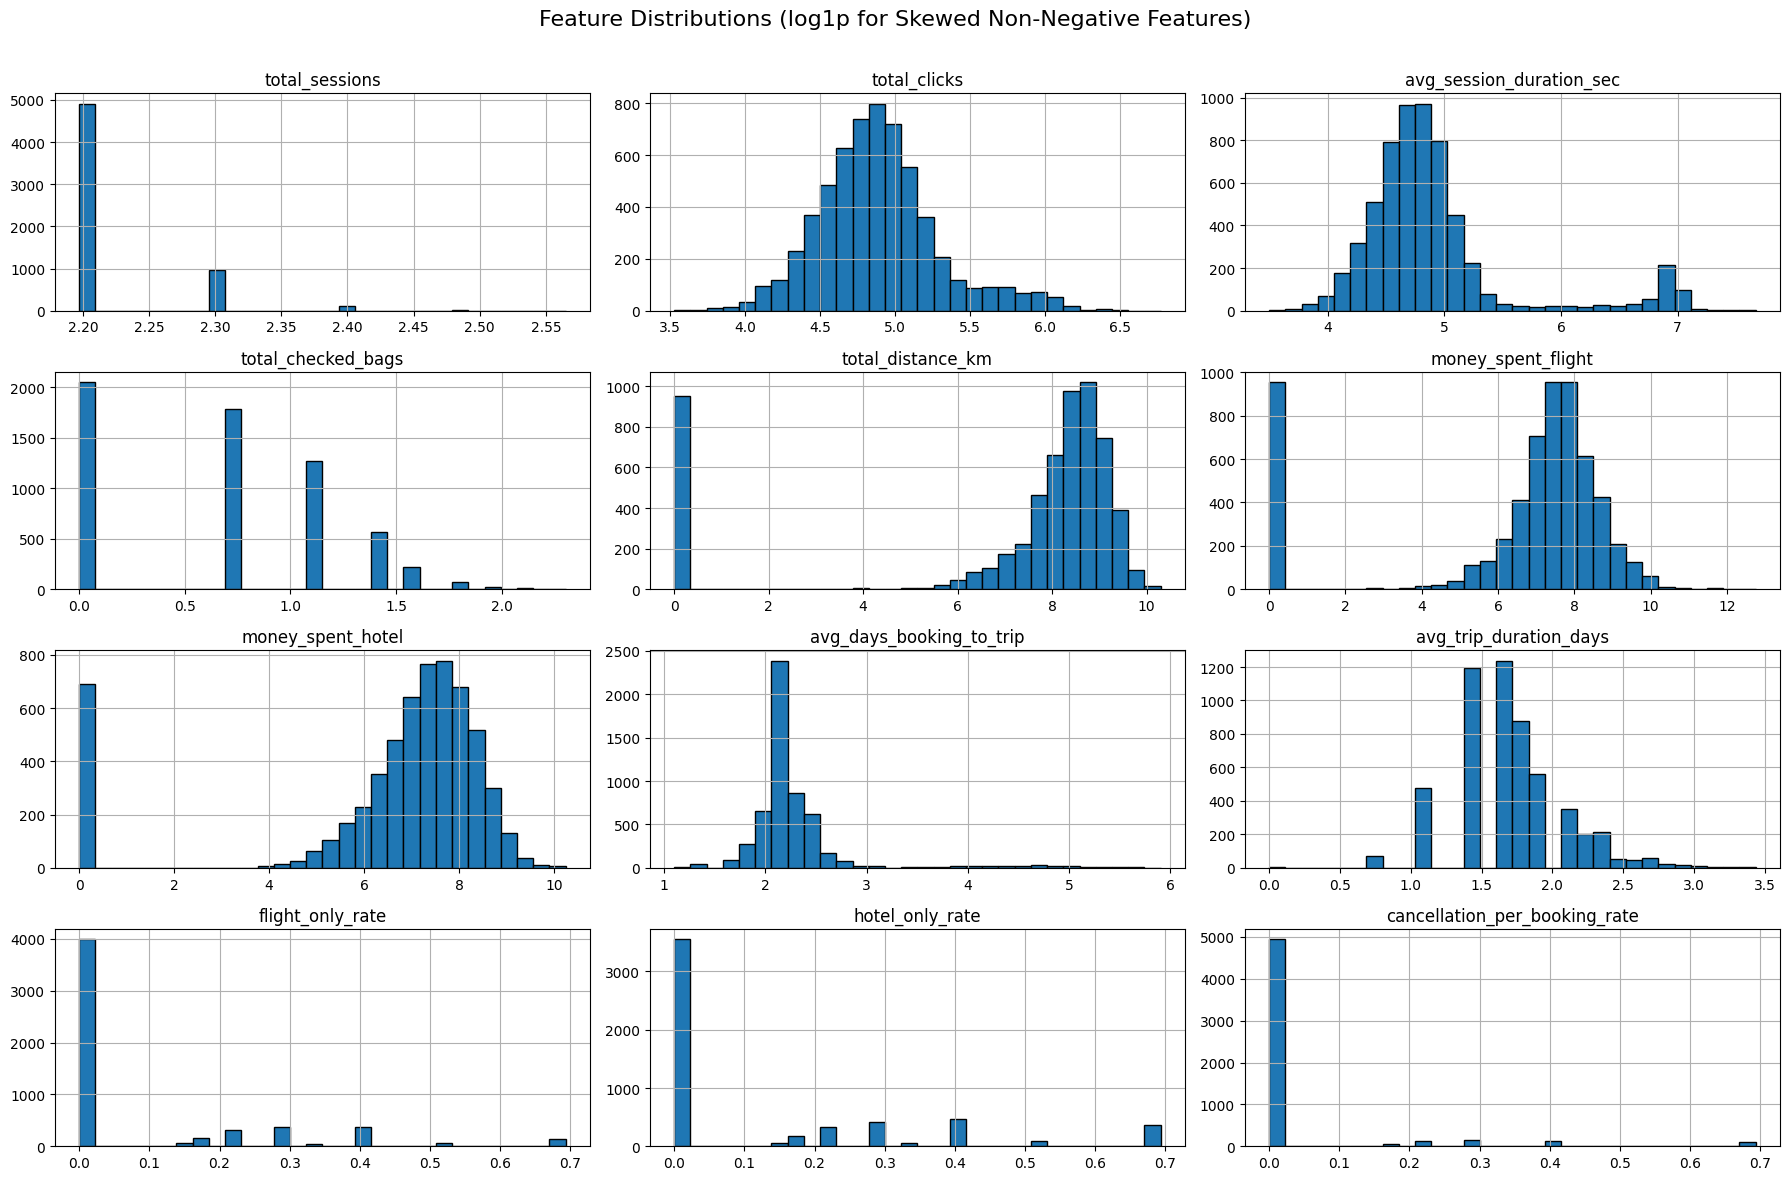

In [3]:
# Numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Prioritized subset (falls back to top numeric if not present)
priority = [
    'avg_session_duration_sec','total_completed_trips','booking_conversion_rate',
    'total_checked_bags','total_distance_km','money_spent_flight',
    'money_spent_hotel','hotel_loyalty_score','avg_days_booking_to_trip',
    'avg_trip_duration_days','discount_usage_rate','cancellation_per_booking_rate'

]
selected = [c for c in priority if c in numeric_cols]
if len(selected) == 0:
    selected = numeric_cols[:min(len(numeric_cols), 12)]

# Zero share diagnostic
zero_share = (df[numeric_cols] == 0).sum().sort_values(ascending=False) / len(df)
print("Top zero-inflated features:")
print(zero_share.head(10).to_string())

# Skew diagnostic
sk = df[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)
print("\nMost positively skewed features:")
print(sk.head(10).to_string())

# Histograms (raw)
ax = df[selected].hist(bins=30, figsize=(18, 12), edgecolor='black')
plt.suptitle('Feature Distributions (Raw)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Log1p histograms for skewed, non-negative features
log_candidates = [c for c in numeric_cols if df[c].min() >= 0 and df[c].skew() > 1]
log_selected = log_candidates[:min(len(log_candidates), 12)]
if len(log_selected) > 0:
    ax = df[log_selected].apply(np.log1p).hist(bins=30, figsize=(18, 12), edgecolor='black')
    plt.suptitle('Feature Distributions (log1p for Skewed Non-Negative Features)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
else:
    print("\nNo highly skewed non-negative features found that benefit from log1p view.")


> **Decision note.** We reviewed skew/zero-inflation across features here to inform transformations later.  
> Only features that are both (a) highly skewed **and** (b) retained for clustering will be log-transformed.  
> This avoids over-processing and keeps transformations aligned with the final feature set.


> **Decision note — `avg_session_duration_sec` (skewed but left unlogged).**  
> The histogram shows right-skew for `avg_session_duration_sec`, which typically suggests a log transform.  
> We A/B tested both variants during modeling:
>
> - **Raw `avg_session_duration_sec`**, k=6 → **Silhouette = 0.4740**  
> - **`log_session_duration_sec`**, k=6 → **Silhouette = 0.4375**
>
> Cluster assignments were **96–97% identical** between the two versions, indicating the log transform did **not** reveal new structure. Given (a) lower clustering quality with the log, and (b) near-identical memberships, we **kept the raw feature** for clarity and better performance.
>
> **Principle used:** *Skew is diagnostic, not prescriptive.* We only transform when it **improves** segmentation quality or stability.


### 2.2 Detect Outliers with Boxplots

To protect the clustering model from distortion, we'll inspect key features using boxplots.

Features we'll focus on:
- `money_spent_flight`
- `money_spent_hotel`
- `avg_days_booking_to_trip`

Outliers in these columns may require transformation, capping, or exclusion.


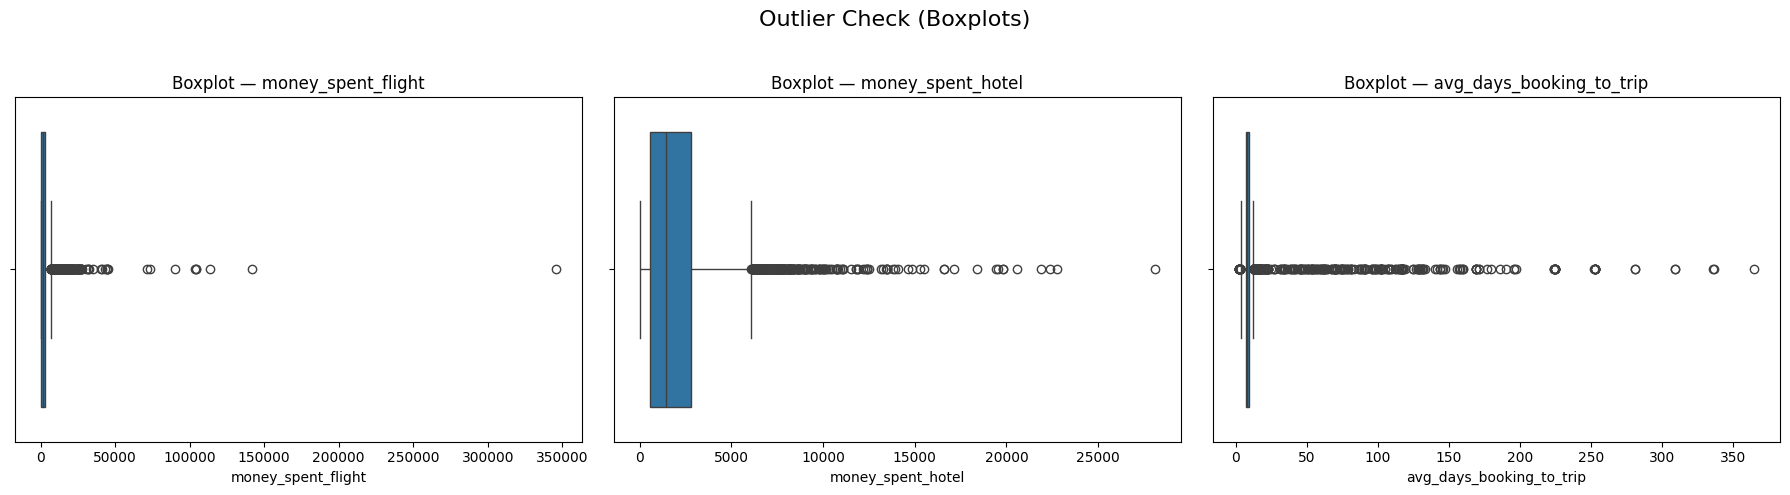

In [4]:
features_to_plot = [
    'money_spent_flight',
    'money_spent_hotel',
    'avg_days_booking_to_trip'
]

# Keep only columns that exist in the DataFrame
cols = [c for c in features_to_plot if c in df.columns]
if len(cols) == 0:
    raise ValueError("None of the requested features exist in the DataFrame.")

# Build subplots
n = len(cols)
fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
if n == 1:
    axes = [axes]  # make iterable

for ax, col in zip(axes, cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"Boxplot — {col}")
    ax.set_xlabel(col)

fig.suptitle("Outlier Check (Boxplots)", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### 2.3 Handle Outliers – Log Transform + Cancellations

In this step we standardize a few fields and create transformed views to reduce the impact of extreme values while keeping all users:

**Rates**
- Set NaNs to `0` for: `flight_only_rate`, `hotel_only_rate`, `both_booked_rate`, `discount_usage_rate`, `cancellation_per_booking_rate` to encode “no events observed.”

**Spend (highly skewed)**
- Apply `log1p()` to both `money_spent_flight` and `money_spent_hotel` to compress right tails while preserving rank order:
  - `log_money_spent_flight`
  - `log_money_spent_hotel`

**Day-based metrics (may be missing for cancelled/unbooked trips)**
- Fill nulls with `-1` for:
  - `avg_days_booking_to_trip`
  - `avg_trip_duration_days`
- Create a custom logged view **only** for `avg_days_booking_to_trip`:
  - `log_avg_days_booking_to_trip` uses `log1p(x)` when `x ≥ 0`, and `0` for the sentinel `-1`.

> Note: The `-1` sentinel marks “unknown/cancelled.”

In [5]:
# --- Rates: encode "no events observed" by replacing NaNs with 0 ---
# Caution: this removes missingness signal; acceptable here since we only need a stable numeric baseline.
df[['flight_only_rate', 'hotel_only_rate', 'both_booked_rate', 'discount_usage_rate', 'cancellation_per_booking_rate']] = \
    df[['flight_only_rate', 'hotel_only_rate', 'both_booked_rate', 'discount_usage_rate', 'cancellation_per_booking_rate']].fillna(0)

# --- Day-based metrics: fill NaNs with -1 to tag cancelled/unbooked/unknown ---
# Warning: -1 is a sentinel, not a real day count.
df['avg_days_booking_to_trip'] = df['avg_days_booking_to_trip'].fillna(-1)
df['avg_trip_duration_days'] = df['avg_trip_duration_days'].fillna(-1)

# --- Spend transforms: compress long right tails while preserving order ---
df['log_money_spent_flight'] = np.log1p(df['money_spent_flight'])
df['log_money_spent_hotel'] = np.log1p(df['money_spent_hotel'])

# --- Custom log view for booking-to-trip days ---
# Applies log1p only to non-negative values; maps sentinel -1 to 0 to keep numeric domain valid.
df['log_avg_days_booking_to_trip'] = df['avg_days_booking_to_trip'].apply(
    lambda x: np.log1p(x) if x >= 0 else 0
)


### 2.4 Correlation Matrix – Check for Redundancy

Before clustering, we explore correlations between features to:

- Detect redundancy (e.g., features that move together)
- Spot multicollinearity that might distort cluster boundaries
- Identify potential candidates for dimensionality reduction or exclusion

We'll plot a heatmap of Pearson correlations.


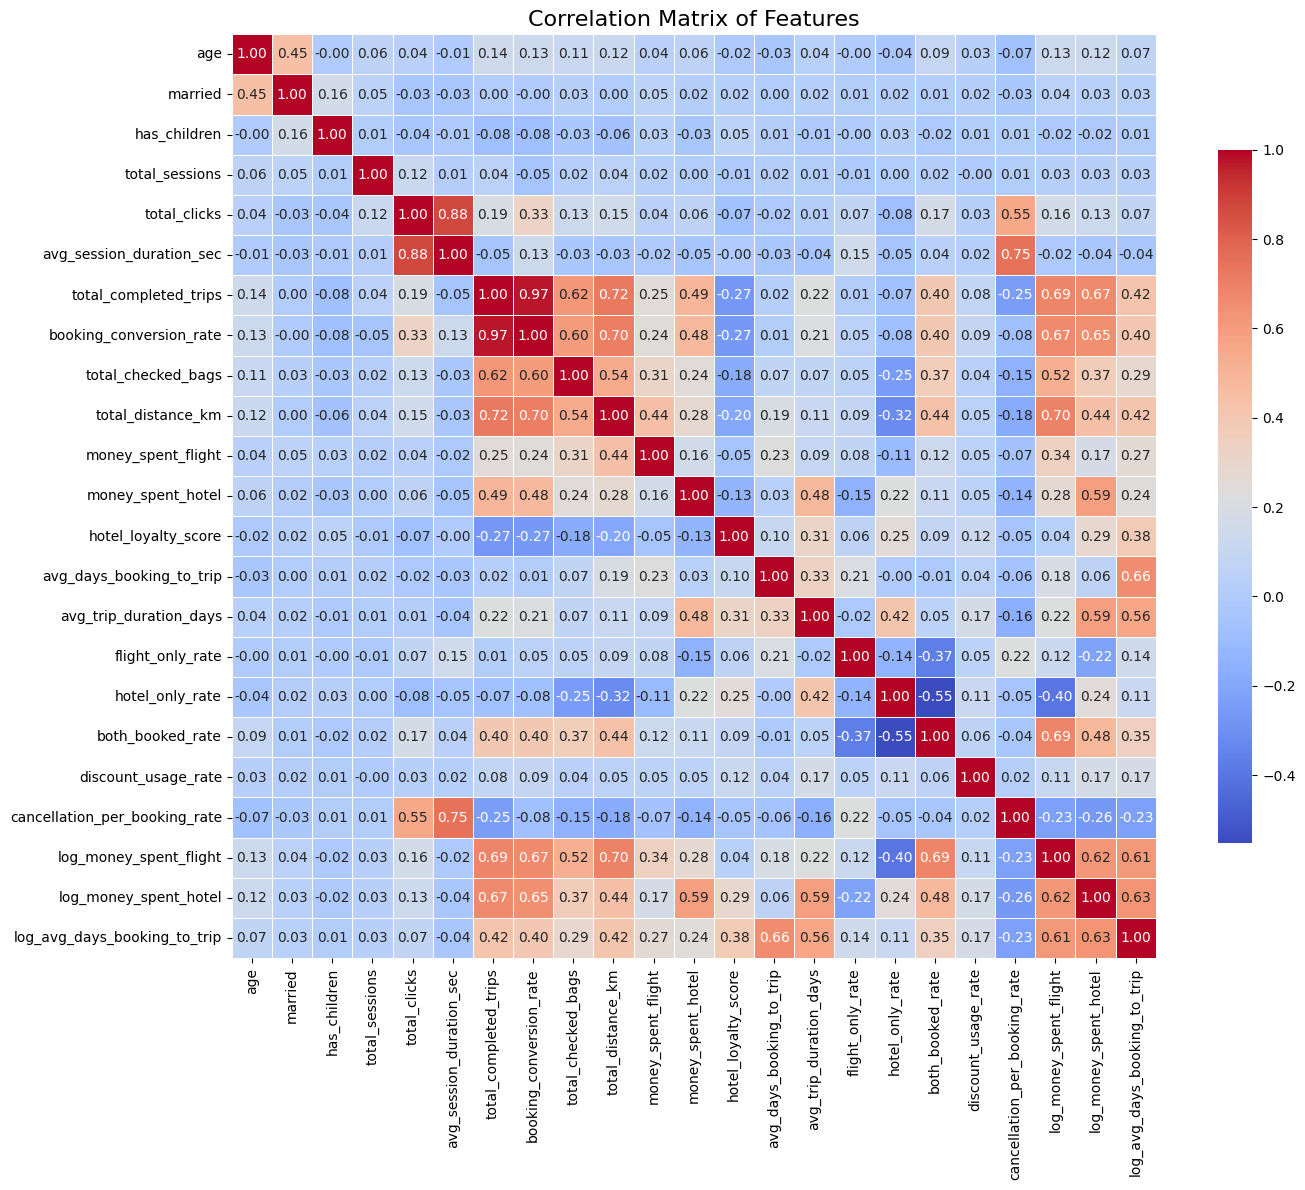

In [6]:
# Exclude user_id and categorical features before correlation
correlation_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['user_id'])

# Compute correlation matrix
corr_matrix = correlation_features.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.75}
)
plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()


### 2.5 Feature Selection for Clustering

Based on the correlation matrix, we removed highly correlated or redundant features to avoid double-weighting behavioral signals:

- **Dropped:** `user_id`, `total_clicks`, `total_completed_trips`, raw `money_spent_hotel`, raw `money_spent_flight`, and raw `avg_days_booking_to_trip`.
- **Kept:** one variable from each correlated pair (e.g., `booking_conversion_rate` in place of total trips).
- **Included transforms where useful:** e.g., `log_money_spent_flight` and `log_money_spent_hotel`.

This yields a balanced feature set ready for scaling and clustering.


In [7]:
# Final list of selected features
selected_features = [
    'age',
    'married',
    'has_children',
    'total_sessions',
    'avg_session_duration_sec',
    'booking_conversion_rate',
    'total_checked_bags',
    'total_distance_km',
    'log_money_spent_hotel',
    'hotel_loyalty_score',
    'log_money_spent_flight',
    'log_avg_days_booking_to_trip',
    'avg_trip_duration_days',
    'flight_only_rate',
    'hotel_only_rate',
    'both_booked_rate',
    'discount_usage_rate',
    'cancellation_per_booking_rate',
]

# Create the input data for clustering
df_final = df[selected_features].copy()
df_final.head()

,age,married,has_children,total_sessions,avg_session_duration_sec,booking_conversion_rate,total_checked_bags,total_distance_km,log_money_spent_hotel,hotel_loyalty_score,log_money_spent_flight,log_avg_days_booking_to_trip,avg_trip_duration_days,flight_only_rate,hotel_only_rate,both_booked_rate,discount_usage_rate,cancellation_per_booking_rate
0,64,1,0,8,77,0.25,0,0,8.208356,0.5,0.000000,2.639057,10.0,0.0,1.0,0.0,0.5,0.0
1,50,1,0,8,68,0.25,1,2907,5.442418,0.5,7.998167,2.197225,2.0,0.0,0.0,1.0,0.0,0.0
2,50,1,1,8,122,0.25,0,965,7.805067,0.5,5.942274,2.197225,5.0,0.0,0.5,0.5,0.0,0.0
3,42,1,0,8,118,0.63,2,6608,7.937017,0.2,7.814561,2.079442,5.0,0.0,0.0,1.0,0.2,0.0
4,44,1,1,8,759,0.13,0,0,0.000000,0.0,0.000000,0.000000,-1.0,0.0,0.0,1.0,0.0,1.0


In [8]:
#Last Check before Scaling
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            5998 non-null   int64  
 1   married                        5998 non-null   int64  
 2   has_children                   5998 non-null   int64  
 3   total_sessions                 5998 non-null   int64  
 4   avg_session_duration_sec       5998 non-null   int64  
 5   booking_conversion_rate        5998 non-null   float64
 6   total_checked_bags             5998 non-null   int64  
 7   total_distance_km              5998 non-null   int64  
 8   log_money_spent_hotel          5998 non-null   float64
 9   hotel_loyalty_score            5998 non-null   float64
 10  log_money_spent_flight         5998 non-null   float64
 11  log_avg_days_booking_to_trip   5998 non-null   float64
 12  avg_trip_duration_days         5998 non-null   f

### 2.6: Scaling Features for Clustering

Since KMeans uses Euclidean distance, it is sensitive to feature scales.

We'll use `StandardScaler` to normalize all features to have:
- Mean = 0
- Standard deviation = 1

This ensures all features contribute equally to clustering.


In [9]:
# Initialize scaler
scaler = StandardScaler()

# Fit and transform
df_final_scaled = scaler.fit_transform(df_final)

# Convert back to DataFrame for easier handling
df_final_scaled = pd.DataFrame(df_final_scaled, columns=selected_features)

# Quick check
df_final_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5998.0,1.279403e-16,1.000083,-2.032681,-0.621491,0.042599,0.623677,3.861114
married,5998.0,2.369266e-18,1.000083,-0.887269,-0.887269,-0.887269,1.127054,1.127054
has_children,5998.0,-1.006938e-17,1.000083,-0.696171,-0.696171,-0.696171,1.436430,1.436430
total_sessions,5998.0,1.421559e-15,1.000083,-0.443872,-0.443872,-0.443872,-0.443872,8.235322
avg_session_duration_sec,5998.0,-2.724655e-17,1.000083,-0.643508,-0.390434,-0.295013,-0.166401,8.093770
booking_conversion_rate,5998.0,3.506513e-16,1.000083,-1.770519,-0.587807,0.003549,0.917463,3.605445
total_checked_bags,5998.0,4.264678e-17,1.000083,-0.990595,-0.990595,-0.199964,0.590666,6.125077
total_distance_km,5998.0,1.232018e-16,1.000083,-1.185111,-0.782036,-0.153397,0.561756,6.311332
log_money_spent_hotel,5998.0,-6.633944e-17,1.000083,-2.583348,-0.057404,0.312716,0.572020,1.493277
hotel_loyalty_score,5998.0,0.000000e+00,1.000083,-1.483849,-0.692505,-0.429779,0.098839,1.681526


## 3.Segmentation Analysis 📊

In this phase we turn the prepared features into meaningful customer segments. The steps below outline the flow:

1) **Set up modeling data** — use the scaled feature matrix prepared in Section 2.  
2) **Explore number of segments** — test a range of k values and compare quality metrics (e.g., elbow, silhouette).  
3) **Fit clustering model(s)** — start with KMeans; consider alternatives only if needed.  
4) **Assign labels** — attach cluster IDs back to the user-level dataset.  
5) **Visualize structure** — use PCA (2D) for interpretation and storytelling (visualization only).  
6) **Diagnose clusters** — check size balance, per-cluster silhouette, and high/low feature patterns.

### 3.1 Principal Component Analysis (PCA)

We use PCA to understand the structure of the scaled feature space:

- Transforms correlated features into uncorrelated components (ordered by variance explained).
- Helps quantify how much variance is captured by the leading components.
- Used here **for visualization and diagnostics only** (e.g., variance plots, 2D scatter); KMeans is trained on the full scaled feature set.


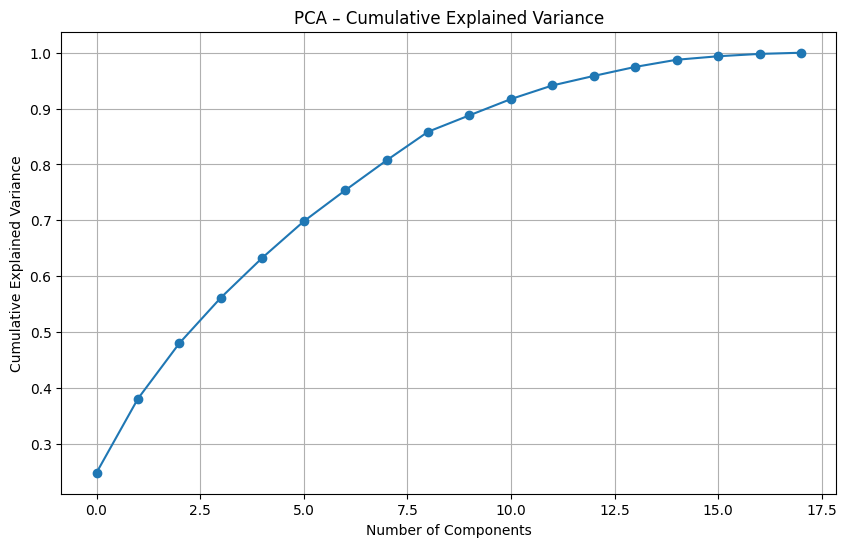

In [10]:
# Fit PCA on the scaled features
pca = PCA()
pca_components = pca.fit_transform(df_final_scaled)

# Plot cumulative variance explained
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA – Cumulative Explained Variance')
plt.grid(True)
plt.show()

### 3.2 Find Optimal Number of Clusters (Elbow & Silhouette)

Before running KMeans, we’ll use two techniques:

- **Elbow Method** — Plot inertia (SSE) to find the point where adding more clusters yields diminishing returns.
- **Silhouette Score** — Measures how distinct and well-separated clusters are (higher is better; ~0.4–0.6+ is common in real data).

We’ll use the full scaled feature matrix from Section 2.6 for clustering, and reserve PCA for visualization later.


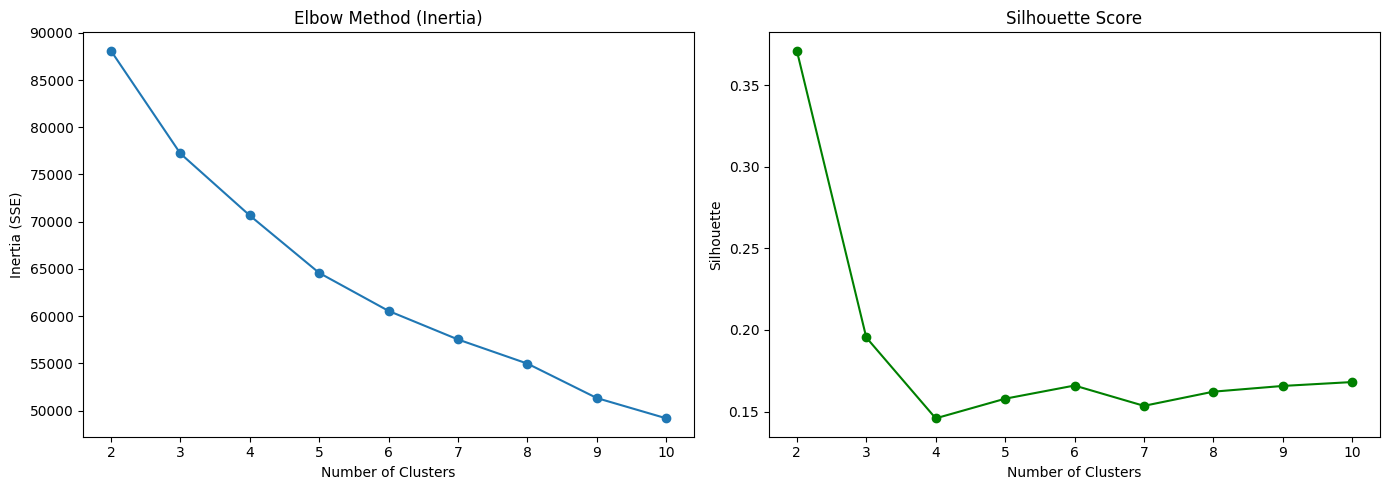


🏅 Top 2 cluster configurations by silhouette score:
1. k = 2 → Silhouette Score = 0.3712
2. k = 3 → Silhouette Score = 0.1954


In [11]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)  # Try 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_final_scaled)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(df_final_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax[0].plot(k_range, inertias, marker='o')
ax[0].set_title('Elbow Method (Inertia)')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Inertia (SSE)')

# Silhouette plot
ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette')

plt.tight_layout()
plt.show()

# 🏆 Print top 2 silhouette scores
top2 = sorted(zip(k_range, silhouette_scores), key=lambda x: x[1], reverse=True)[:2]
print("\n🏅 Top 2 cluster configurations by silhouette score:")
for i, (k, score) in enumerate(top2, start=1):
    print(f"{i}. k = {k} → Silhouette Score = {score:.4f}")

### 3.3 Run KMeans with k=4 Clusters

Based on the Elbow and Silhouette analysis, we choose **k = 4** as the working number of clusters.

We will:
- Fit KMeans on the final **scaled feature set**
- Assign each user to a cluster
- Merge the cluster labels back into the original DataFrame


In [12]:
# Fit KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(df_final_scaled)

# Add cluster labels to original df
df['cluster'] = kmeans.labels_

# Preview
df['cluster'].value_counts()

,count
cluster,
0,2464
2,2404
1,635
3,495


### 3.4 Cluster Profiling – Behavioral Fingerprints

To understand what defines each cluster, we compute the **cluster-level averages** of the modeling features.  
For binary fields (e.g., `married`, `has_children`), the mean is interpretable as the **share** of users in the cluster with that attribute.

This view highlights distinct behavioral traits and supports clear, persona-style descriptions.


In [13]:
# Include cluster column with final features
features_for_profile = selected_features + ['cluster']

# Compute cluster-wise averages
cluster_profiles = df[features_for_profile].groupby('cluster').mean().round(2)

# Display transposed for better readability
cluster_profiles.T

cluster,0,1,2,3
age,42.54,36.63,39.86,38.26
married,0.44,0.38,0.46,0.41
has_children,0.27,0.33,0.38,0.35
total_sessions,8.21,8.17,8.21,8.20
avg_session_duration_sec,176.55,213.60,194.40,170.23
booking_conversion_rate,0.49,0.04,0.26,0.20
total_checked_bags,2.22,0.08,0.80,0.12
total_distance_km,7937.85,284.59,3433.67,297.44
log_money_spent_hotel,7.74,0.00,6.74,7.41
hotel_loyalty_score,0.32,0.00,0.67,0.83


### 🔄 3.5 Drop Low-Impact Features & Re-scale for Clustering

After reviewing the first clustering pass, we removed features that showed little separation contribution (e.g., `age`, `discount_usage_rate`, `flight_only_rate`). This trims dimensional noise and sharpens segment boundaries.

Steps:
1) Define low-impact features to drop.  
2) Build a reduced feature set.  
3) Re-apply `StandardScaler` to the reduced matrix (fresh fit on the new columns).

> Note: Features dropped from clustering can still be used later for **profiling only** (interpretation), even if they’re excluded from the model input.


In [14]:
# Define weak features to drop
low_impact_features = [
    'age',
    'married',
    'has_children',
    'total_sessions',
    'flight_only_rate',
    'hotel_only_rate',
    'discount_usage_rate',
    'hotel_loyalty_score',
    'log_avg_days_booking_to_trip',
    'avg_trip_duration_days',
    'both_booked_rate',
    'total_checked_bags',
    'total_distance_km'
]

# Create reduced feature set from what was originally selected
reduced_features = [col for col in selected_features if col not in low_impact_features]

# Scale the reduced features (fresh fit on reduced set)

scaler = StandardScaler()
df_reduced_scaled = scaler.fit_transform(df[reduced_features])
reduced_features

['avg_session_duration_sec',
 'booking_conversion_rate',
 'log_money_spent_hotel',
 'log_money_spent_flight',
 'cancellation_per_booking_rate']

> **Note on experimentation scope**  
> Between the baseline and final runs, we tested multiple alternatives (feature sets, transforms, scalers, and models).  
> For clarity, this notebook shows only the **original** and the **final** pipelines; a brief experiment summary is provided in the appendix.



### 3.6 PCA – Explained Variance of Reduced Feature Set

With the filtered and re-scaled dataset, we use PCA to quantify how much variance is captured by the leading components.  
This is for diagnostics/visualization only; clustering continues to use the full reduced feature space.


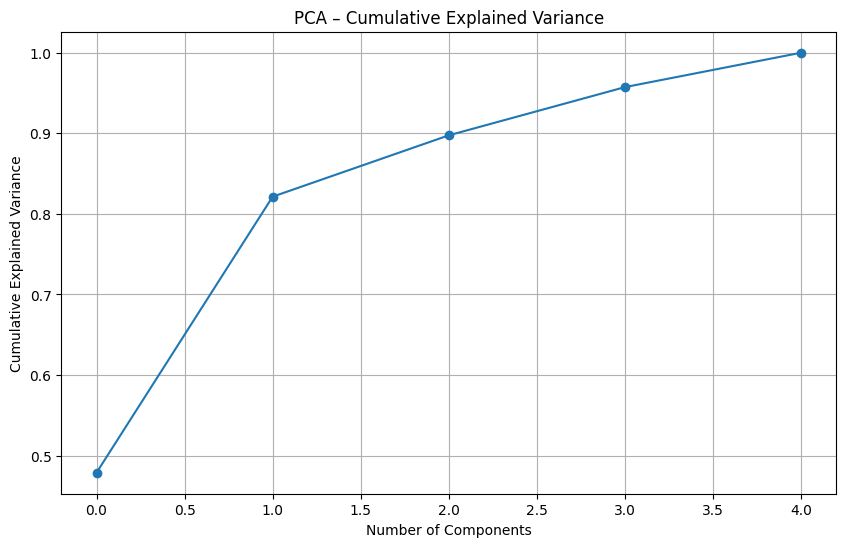

In [15]:
# Run PCA on the scaled data
pca = PCA()
pca_components = pca.fit_transform(df_reduced_scaled)

# Plot variance explained by each component
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA – Cumulative Explained Variance')
plt.grid(True)
plt.show()

### 3.7 Elbow & Silhouette Analysis on Refined Feature Set

Using the **reduced, re-scaled** feature matrix, we assess candidate values of `k`:

- **Elbow (Inertia/SSE):** look for the point of diminishing returns as `k` increases.
- **Silhouette Score:** higher indicates better separation (common real-world targets ~0.4–0.6+).

We evaluate `k = 2…10` and rank configurations by silhouette to guide the final KMeans choice.


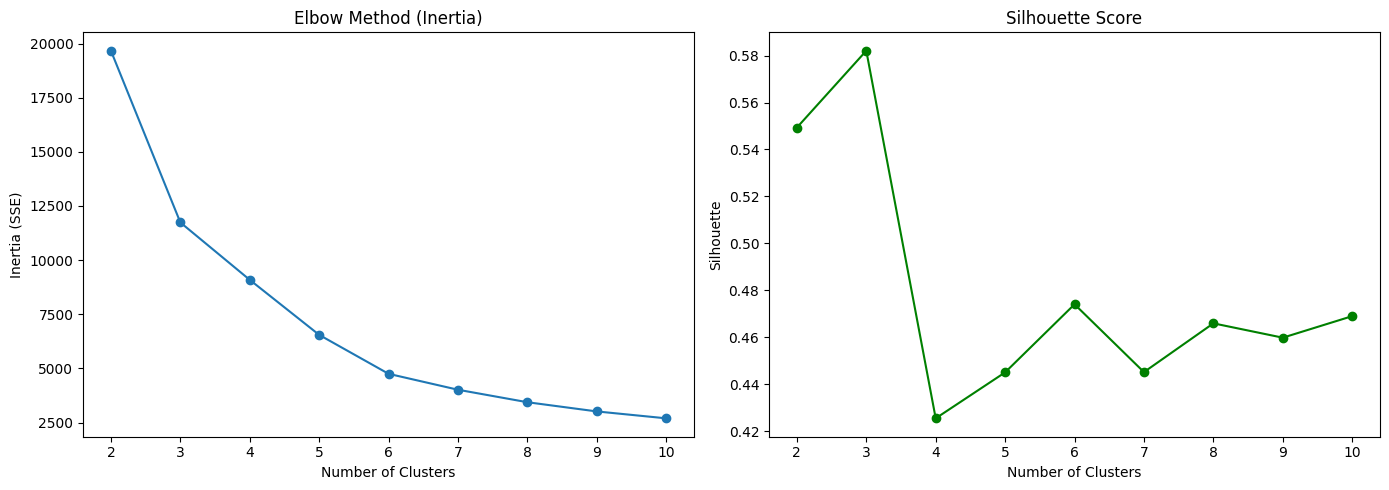


🏅 Cluster configurations by silhouette score:
1. k = 3 → Silhouette Score = 0.5821
2. k = 2 → Silhouette Score = 0.5493
3. k = 6 → Silhouette Score = 0.4740
4. k = 10 → Silhouette Score = 0.4690
5. k = 8 → Silhouette Score = 0.4659
6. k = 9 → Silhouette Score = 0.4598
7. k = 7 → Silhouette Score = 0.4451
8. k = 5 → Silhouette Score = 0.4450
9. k = 4 → Silhouette Score = 0.4254


In [16]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)  # Try 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_reduced_scaled)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(df_reduced_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
ax[0].plot(k_range, inertias, marker='o')
ax[0].set_title('Elbow Method (Inertia)')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Inertia (SSE)')

# Silhouette plot
ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette')

plt.tight_layout()
plt.show()

# Ranked silhouette scores (best to worst)
top = sorted(zip(k_range, silhouette_scores), key=lambda x: x[1], reverse=True)[:11]
print("\n🏅 Cluster configurations by silhouette score:")
for i, (k, score) in enumerate(top, start=1):
    print(f"{i}. k = {k} → Silhouette Score = {score:.4f}")

### 3.8 Final KMeans Clustering with k=6

Based on the silhouette analysis, we fit the final KMeans model with **k = 6** on the **reduced, re-scaled** feature matrix.

Each user is assigned to **one of six clusters** based on behavioral features, and the labels are appended to the original DataFrame for downstream interpretation and profiling.

We also review the **distribution of users per cluster** to check for balance or dominance by any single group.


In [17]:
# Fit KMeans with k=6
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans.fit(df_reduced_scaled)

# Add cluster labels to original df
df['cluster'] = kmeans.labels_

# Preview
df['cluster'].value_counts()

,count
cluster,
5,2915
0,1612
2,573
1,423
3,375
4,100


## 4.Cluster Profiling 🧩 — Final Model

Goal: translate cluster IDs into understandable behaviors.

We’ll do three quick passes:
1) **Sizes & means** — average of the modeling features per cluster.  
2) **Standardized fingerprints** — z-scored means vs. overall, to spotlight what’s unusually high/low in each cluster.  
3) **Standout features** — top positive/negative signals per cluster to aid naming and perk alignment.

> Note: Features dropped from modeling can still appear here for interpretation if included.


### 4.1 Cluster Profiling – Behavioral Fingerprints

Now that users have been segmented into 6 clusters, we compute the **average value of each feature per cluster** to interpret the dominant behaviors and traits within each group.

This cluster profiling step is essential for:
- Understanding the behavioral DNA of each segment
- Linking clusters to likely perk preferences
- Supporting persona creation and storytelling

The result is a transposed summary table that highlights **which features are most distinctive per cluster**, making it easier to define user personas and recommend personalized rewards.


In [18]:
# Create a trip duration bucket for readability
def bucket_trip_duration(days):
    if days == -1:
        return 'no_trip'
    elif days <= 3:
        return 'short'
    elif days <= 7:
        return 'medium'
    else:
        return 'long'

df['trip_duration_type'] = df['avg_trip_duration_days'].apply(bucket_trip_duration)


In [19]:
# Choose profiling features (raw features are OK for interpretation)
profiling_features = [
       'age', 'married', 'has_children', 'total_sessions',
       'total_clicks', 'avg_session_duration_sec', 'total_completed_trips',
       'booking_conversion_rate', 'total_checked_bags', 'total_distance_km',
       'money_spent_flight', 'money_spent_hotel', 'hotel_loyalty_score',
       'avg_days_booking_to_trip','flight_only_rate', 'hotel_only_rate',
       'both_booked_rate', 'discount_usage_rate', 'cancellation_per_booking_rate'
]

In [20]:
#Cluster-wise means (transposed later for readability)
features_for_profile = profiling_features + ['cluster']

cluster_profiles = df[features_for_profile].groupby('cluster').mean().round(2)

In [21]:
# Distribution of trip duration buckets per cluster
trip_duration_dist = df.groupby('cluster')['trip_duration_type'].value_counts().unstack().fillna(0).astype(int)

In [22]:
#Display profiles
print("📊 Numeric Cluster Profiles:")
display(cluster_profiles.T)

print("\n📊 Trip Duration Type per Cluster:")
display(trip_duration_dist)


📊 Numeric Cluster Profiles:


cluster,0,1,2,3,4,5
age,42.24,41.08,37.41,38.35,32.55,40.58
married,0.44,0.41,0.40,0.42,0.34,0.46
has_children,0.27,0.34,0.33,0.35,0.33,0.35
total_sessions,8.20,8.27,8.17,8.20,8.14,8.20
total_clicks,154.15,334.88,94.53,105.27,243.63,122.61
avg_session_duration_sec,143.56,944.24,86.56,100.59,774.83,112.05
total_completed_trips,4.51,2.25,0.23,1.25,0.00,2.29
booking_conversion_rate,0.56,0.40,0.03,0.16,0.13,0.28
total_checked_bags,2.26,1.09,0.14,0.03,0.00,1.14
total_distance_km,8309.95,4094.64,583.85,8.46,0.00,4348.53



📊 Trip Duration Type per Cluster:


trip_duration_type,long,medium,no_trip,short
cluster,,,,
0,90,1108,0,414
1,40,234,4,145
2,22,21,457,73
3,169,141,5,60
4,0,0,100,0
5,313,1521,27,1054


#### 📎 Notes on Profiling Interpretation

- **Purpose over precision:** Profiling here emphasizes **behavioral patterns**, not exact spending amounts. Heavy-tailed metrics (e.g., `money_spent_*`, `total_*`) may inflate means, but the **relative ordering across clusters** is what drives interpretation and perk mapping.
- **Lead-time field:** `avg_days_booking_to_trip` was **low-influence** for cluster characterization and is included only for context. The `-1` sentinel denotes cancellations/unknown and does not affect our modeling conclusions.
- **Why not log/median here?** During experimentation we verified that logging/selecting alternative summaries **did not change cluster identities or narratives** in a meaningful way. We keep means for clarity and comparability with earlier tables.
- **Takeaway:** Persona insights and perk alignment rely on **consistent multi-feature patterns** (e.g., distance, bags, session behavior, booking mix), not any single absolute value.


### 4.2 Cluster-by-Cluster Behavioral Analysis

We now zoom into each individual cluster to better understand its defining traits, behavioral patterns, and which perks would best resonate with its members.

Each cluster is analyzed in terms of:
- Travel frequency and conversion behavior
- Spending habits (flight & hotel)
- Loyalty indicators (e.g., booking combinations, advance planning)
- Trip duration types
- Demographic and engagement patterns
- Suggested perks based on behavioral insights

---

#### 4.2.0 🟢 Cluster 0 – "Premium Frequent Travelers"

#### 👥 Segment Summary
Cluster 0 with **1,612 users** (**26.87% of all users**) represents **high-value, committed travelers** who consistently book both flights and hotels.  
They have the **highest total distance traveled**, **highest spending** in both flights and hotels, and the **highest booking conversion rate** in the dataset.  
Their cancellation rate is extremely low, and they tend to take medium-length trips, often with multiple checked bags — indicating longer or more complex itineraries.

**Key behavioral signs:**
- Highest booking conversion rate (0.56).
- Highest total distance traveled (8,309.87 km avg per user).
- Highest spend: \$5,307.31 on flights and \$3,420.32 on hotels.
- High both-booked rate (0.78) — strongly prefer flight+hotel packages.
- Low hotel loyalty score (0.29) — spread stays across brands.
- Low cancellation rate (0.01).
- Medium advance booking (~10.4 days before travel).

---

#### 📊 Key Behavioral Metrics (Cluster 0)
| Metric | Value |
|--------|-------|
| Users in cluster | 1,612 |
| Share of total users | 26.87% |
| Avg. age | 42.24 |
| Married (%) | 44% |
| Has children (%) | 27% |
| Total sessions | 8.21 |
| Avg. session duration (sec) | 143.78 |
| Total clicks | 154.07 |
| Total completed trips | 4.51 |
| Booking conversion rate | **0.56** |
| Flight spend | **\$5,307.31** |
| Hotel spend | **\$3,420.32** |
| Hotel loyalty score | 0.29 |
| Discount usage rate | 0.26 |
| Cancellation rate per booking | 0.01 |

---

#### 🧭 Trip Duration Breakdown
Ranked by share of cluster members:
1. **Medium trips** – 1,108 users
2. **Short trips** – 414 users
3. **Long trips** – 90 users
4. **No trip** – 0 users

---

#### 🎯 Recommended Perks for Cluster 0
This segment is best served by **value-rich package rewards** and **loyalty recognition**.

| Priority | Perk | Rationale |
|---------|------|-----------|
| ⭐ Top   | **🏨 “1 Free Hotel Night with Flight”** | Matches high flight+hotel booking rate and large hotel spend. |
| ⭐ Top   | **🎁 VIP / Elite Tier Benefits** | Encourages loyalty in high-spend travelers who aren’t tied to one hotel brand. |
| 🥈 Alt   | **💼 Free Checked Bag** | Supports long-distance trips with multiple bags. |
| 🥉 Optional | **📅 Priority Booking Window** | Rewards frequent planners booking ~10 days out.

💡 These are TravelTide’s **most profitable and committed customers** — perks should focus on **deepening loyalty** and **securing future bookings**.

**Final Locked Perk for DataFrame**  
🏨 **1 Free Hotel Night with Flight**  

**Justification:** This is TravelTide’s most profitable and committed customer segment, with the highest booking conversion rate, highest spend in both flights and hotels, and a strong preference for combined flight+hotel packages. Their extremely low cancellation rate and consistent medium trip patterns make them ideal candidates for high-value rewards. Offering a free hotel night bundled with a flight purchase both rewards their loyalty and further incentivizes them to continue booking complete travel packages through TravelTide.

---


#### 4.2.1 🟣 Cluster 1 – "Change-Prone Travelers"

#### 👥 Segment Summary
Cluster 1 with **423 users** (**7.05% of all users**) consists of travelers who **often cancel bookings and re-plan their trips**.  
They record the **highest cancellation rate** among active customers, and this directly drives their high click counts and session durations — not because they are exploring more destinations, but because the cancellation process takes time and effort.  
Despite spending considerable time on the platform, their completed trip count is relatively low for their activity level.

**Key behavioral signs:**
- **Very high cancellation rate** among active clusters (0.35 per booking).
- Long average session times (944 sec) and high click counts (335), likely due to the cancellation process and re-booking steps.
- Completed trips are modest (2.25 avg) compared to time spent on the site.
- Balanced spend between flights and hotels, but far from the top spenders.
- Medium trips dominate, followed by short trips.
- Booking conversion is moderate (0.40) — cancellations keep net results lower.

---

#### 📊 Key Behavioral Metrics (Cluster 1)
| Metric | Value |
|--------|-------|
| Users in cluster | 423 |
| Share of total users | 7.05% |
| Avg. age | 41.08 |
| Married (%) | 41% |
| Has children (%) | 34% |
| Total sessions | 8.27 |
| Avg. session duration (sec) | **944.24** |
| Total clicks | 334.88 |
| Total completed trips | 2.25 |
| Booking conversion rate | 0.40 |
| Flight spend | \$2,394.98 |
| Hotel spend | \$1,682.27 |
| Hotel loyalty score | 0.59 |
| Discount usage rate | 0.26 |
| Cancellation rate per booking | **0.35** |

---

#### 🧭 Trip Duration Breakdown
Ranked by share of cluster members:
1. **Medium trips** – 234 users
2. **Short trips** – 145 users
3. **Long trips** – 40 users
4. **No trip** – 4 users

---

#### 🎯 Recommended Perks for Cluster 1
This segment is best served by **perks that reduce cancellations and increase booking commitment**.

| Priority | Perk | Rationale |
|---------|------|-----------|
| ⭐ Top   | **✅ Free Cancellation** | Reduces hesitation, making them more willing to commit early. |
| ⭐ Top   | **🤝 Booking Assistant / Trip Concierge** | Helps manage re-planning with less friction and time cost. |
| 🥈 Alt   | **💰 Price Lock / Hold My Fare** | Prevents cancellations caused by fear of missing a better deal. |
| 🥉 Optional | **📩 Smart Reminders & Saved Itineraries** | Keeps bookings visible, encouraging follow-through without repeated browsing.

💡 Their time on platform is **reactive, not exploratory** — driven by booking reversals rather than discovery. Reducing the need to cancel is key to improving value.

**Final Locked Perk for DataFrame**  
✅ **Free Cancellation**  

**Justification:** While this group currently shows high cancellation rate, the behavior is likely driven by uncertainty and fear of losing flexibility rather than an intent to abandon bookings. By removing the financial penalty for changing plans, we reduce that anxiety and make it easier for them to commit earlier. This “safety net” approach encourages them to book confidently through TravelTide, knowing they can adjust if needed — ultimately leading to more confirmed trips and stronger platform loyalty.

---

#### 4.2.2 🟡 Cluster 2 – "Window Shoppers"

#### 👥 Segment Summary
Cluster 2 with **573 users** (**9.55% of all users**) represents **cold leads and light browsers** who rarely commit to bookings.  
Most have **no completed trips**, spend almost nothing, and interact minimally with the platform.  
Their low discount usage rate and negligible hotel spend suggest they haven’t experienced the platform’s full value proposition.

**Key behavioral signs:**
- Very low booking conversion rate (0.03).
- Vast majority (80%) have no trips.
- Minimal flight spend ($365.41) and zero hotel spend.
- Lowest hotel loyalty score (0.05).
- Low engagement: 94.53 clicks, 86.56 sec average session time.  


---

#### 📊 Key Behavioral Metrics (Cluster 2)
| Metric | Value |
|--------|-------|
| Users in cluster | 573 |
| Share of total users | 9.55% |
| Avg. age | 37.41 |
| Married (%) | 40% |
| Has children (%) | 33% |
| Total sessions | 8.17 |
| Avg. session duration (sec) | 86.56 |
| Total clicks | 94.53 |
| Total completed trips | 0.23 |
| Booking conversion rate | **0.03** |
| Flight spend | \$365.41 |
| Hotel spend | \$0.00 |
| Hotel loyalty score | 0.05 |
| Discount usage rate | 0.06 |
| Cancellation rate per booking | 0.00 |

---

#### 🧭 Trip Duration Breakdown
Ranked by share of cluster members:
1. **No trip** – 457 users
2. **Short trips** – 73 users
3. **Long trips** – 22 users
4. **Medium trips** – 21 users

---

#### 🎯 Recommended Perks for Cluster 2
This segment is best served by **activation-focused perks** to convert browsers into first-time bookers.

| Priority | Perk | Rationale |
|---------|------|-----------|
| ⭐ Top   | **💰 First-Booking Discount** | Creates a strong incentive to make their first booking. |
| ⭐ Top   | **✈️ Flight-Only Flash Deals** | Aligns with their low hotel usage and minimal trip distances. |
| 🥈 Alt   | **✅ Free Cancellation** | Reduces hesitation for first-time bookings. |
| 🥉 Optional | **🎯 “Complete Your Booking” Reward** | Motivates users to finalize trips they start.

💡 This segment needs **first-trip conversion** above all else , activation — once they experience the service, retention tactics can follow.

**Final Locked Perk for DataFrame**  
💰 **First-Booking Discount**  

**Justification:**  
This cluster consists mainly of cold leads and light browsers who have yet to experience the value of TravelTide’s service.  
With a booking conversion rate of just 3% and virtually no hotel spend, the primary challenge is **activation** — motivating them to make that crucial first booking.  

A **First-Booking Discount** directly addresses their hesitation by lowering the perceived risk and increasing the immediate reward of trying the platform.  
Once they complete a first trip, follow-up retention tactics and upselling can be applied to build loyalty and increase lifetime value.

---

#### 4.2.3 🔵 Cluster 3 – "Hotel Loyalists"

#### 👥 Segment Summary
Cluster 3 with **375 users** (**6.25% of all users**) is dominated by **hotel-only, long-stay travelers** who show extremely high brand loyalty.  
They rarely book flights, spend heavily on hotels, and travel very short distances — suggesting local or near-destination stays.  
Their hotel loyalty score is the **highest of all clusters**, making them prime candidates for hotel-focused retention efforts.

**Key behavioral signs:**
- 95% of bookings are hotel-only.
- Highest hotel loyalty score (0.89) — repeat bookings with the same brands.
- Modest booking conversion rate (0.16).
- Minimal flight spend (\$1.18) vs. significant hotel spend (\$2,278.35).
- Very short travel distances (8.46 km avg per user).
- Long trips are most common, followed by medium trips.
- Low cancellation rate (0.01).

---

#### 📊 Key Behavioral Metrics (Cluster 3)
| Metric | Value |
|--------|-------|
| Users in cluster | 375 |
| Share of total users | 6.25% |
| Avg. age | 38.35 |
| Married (%) | 42% |
| Has children (%) | 35% |
| Total sessions | 8.20 |
| Avg. session duration (sec) | 100.59 |
| Total clicks | 110.88 |
| Total completed trips | 1.25 |
| Booking conversion rate | 0.16 |
| Flight spend | \$1.18 |
| Hotel spend | \$2,278.35 |
| Hotel loyalty score | **0.89** |
| Discount usage rate | 0.34 |
| Cancellation rate per booking | 0.01 |

---

#### 🧭 Trip Duration Breakdown
Ranked by share of cluster members:
1. **Long trips** – 169 users
2. **Medium trips** – 141 users
3. **Short trips** – 60 users
4. **No trip** – 5 users

---

#### 🎯 Recommended Perks for Cluster 3
This segment is best served by **hotel loyalty rewards** and **long-stay benefits**.

| Priority | Perk | Rationale |
|---------|------|-----------|
| ⭐ Top   | **🏨 Extended Stay Discounts** | Directly rewards their long hotel trips. |
| ⭐ Top   | **✨ Complimentary Upgrades / Free Breakfast** | Matches their loyalty and comfort-oriented stays. |
| 🥈 Alt   | **📅 Priority Check-in & Late Checkout** | Improves experience during long stays. |
| 🥉 Optional | **🎁 Stay X Nights, Get 1 Free** | Further strengthens repeat hotel bookings.

💡 This is a **strategic hotel partner segment** — keeping them on-platform for every hotel stay is the retention priority.

**Final Locked Perk for DataFrame**  
🏨 **Extended Stay Discounts**  

**Justification:** This cluster’s travel patterns are built around long hotel stays with very high brand loyalty, making them prime candidates for rewards that extend and enrich those stays. By offering a discount for extended bookings, we directly reinforce their natural behavior while deepening retention. This perk also strengthens our partnerships with hotel brands by driving more high-value, long-duration bookings through the platform.

---

#### 4.2.4 🟠 Cluster 4 – "Serial Cancellers"

#### 👥 Segment Summary
Cluster 4 with **100 users** (**1.67% of all users**) consists of travelers who **book multiple times but cancel 100% of their trips**.  
They are also the **youngest group in the dataset** (avg. age 32.55), which may point to different travel patterns, budget sensitivity, or less stable plans compared to older segments.  
Despite showing reasonable booking conversion rates and trip type variety, none of their bookings are ever completed.  
This behavior suggests a combination of **commitment hesitation**, **changing travel plans**, or **using the platform for price checking without intent to travel**.

**Key behavioral signs:**
- Youngest cluster (avg. age 32.55).
- 100% cancellation rate across multiple bookings.
- Zero completed trips despite a 0.13 booking conversion rate.
- Bookings split between flight-only (42%) and both flight+hotel (51%).
- No spend on flights or hotels due to all trips being canceled.
- Hotel loyalty score = 0.00 — no actual stays.
- Moderate session duration (774 sec) and clicks (244) — indicating real booking activity, but no follow-through.

---

#### 📊 Key Behavioral Metrics (Cluster 4)
| Metric | Value |
|--------|-------|
| Users in cluster | 100 |
| Share of total users | 1.67% |
| Avg. age | **32.55** |
| Married (%) | 34% |
| Has children (%) | 33% |
| Total sessions | 8.14 |
| Avg. session duration (sec) | 774.83 |
| Total clicks | 244.44 |
| Total completed trips | 0.00 |
| Booking conversion rate | 0.13 |
| Flight spend | \$0.00 |
| Hotel spend | \$0.00 |
| Hotel loyalty score | 0.00 |
| Discount usage rate | 0.26 |
| Cancellation rate per booking | **1.00** |

---

#### 🧭 Trip Duration Breakdown
Ranked by share of cluster members:
1. **No trip** – 100 users
2. **Short trips** – 0 users
3. **Long trips** – 0 users
4. **Medium trips** – 0 users

---

#### 🎯 Recommended Perks for Cluster 4
This segment requires **confidence-building perks** and **commitment incentives** to turn bookings into completed trips.

| Priority | Perk | Rationale |
|---------|------|-----------|
| ⭐ Top   | **💰 “Travel or Credit” Offer** | If they cancel, credit goes toward a future trip instead of refund — encourages rebooking. |
| ⭐ Top   | **✅ Flexible Booking Guarantee** | Reduces anxiety over committing to a trip. |
| 🥈 Alt   | **🎯 Post-Cancellation Targeted Deals** | Prompt follow-up offers to encourage immediate rebooking. |
| 🥉 Optional | **📞 Priority Support for Itinerary Changes** | Makes modifying trips easier without canceling entirely.

💡 This group has **intent but no follow-through** — the focus is to **convert planned trips into actual travel** rather than just bookings.  
Special consideration should be given to their **younger demographic**, which may respond better to **flexibility, last-minute deals, and reassurance**.

**Final Locked Perk for DataFrame**  
💰 **“Travel or Credit” Offer**  

**Justification:** This segment books trips but cancels 100% of them, meaning no completed travel and zero spend. The “Travel or Credit” model ensures that cancellations retain value for both the customer and TravelTide — instead of refunds disappearing off-platform, funds are held as credit for a future trip. This keeps customers engaged, encourages rebooking, and builds commitment without removing flexibility, making it particularly effective for this younger, less predictable travel group.


---


#### 4.2.5 🔴 Cluster 5 – "Balanced Frequent Travelers"

#### 👥 Segment Summary
Cluster 5 with **2,915 users** (**48.61% of all users**) is the largest segment and represents **frequent, reliable travelers** with a balanced mix of short and medium trips.  
They show strong booking activity, low cancellation rates, and a healthy balance between flights and hotels.  
Their hotel loyalty score is among the highest, and they book well in advance, indicating a mix of planned leisure travel and repeat patterns.

**Key behavioral signs:**
- Largest customer group — nearly half the entire user base.
- Strong trip completion (2.29 trips avg) with low cancellation rate (0.00).
- Balanced spending: \$2,515.78 flights, \$1,759.63 hotels.
- Above-average hotel loyalty score (0.59).
- Good booking conversion rate (0.28).
- Majority take medium trips, but short trips are also significant.
- Book on average ~12.8 days in advance.

---

#### 📊 Key Behavioral Metrics (Cluster 5)
| Metric | Value |
|--------|-------|
| Users in cluster | 2,915 |
| Share of total users | 48.61% |
| Avg. age | 40.58 |
| Married (%) | 46% |
| Has children (%) | 35% |
| Total sessions | 8.20 |
| Avg. session duration (sec) | 112.05 |
| Total clicks | 124.78 |
| Total completed trips | 2.29 |
| Booking conversion rate | 0.28 |
| Flight spend | \$2,515.78 |
| Hotel spend | \$1,759.63 |
| Hotel loyalty score | 0.59 |
| Discount usage rate | 0.27 |
| Cancellation rate per booking | **0.00** |

---

#### 🧭 Trip Duration Breakdown
Ranked by share of cluster members:
1. **Medium trips** – 1,521 users
2. **Short trips** – 1,054 users
3. **Long trips** – 313 users
4. **No trip** – 27 users

---

#### 🎯 Recommended Perks for Cluster 5
This segment is best served by **loyalty and retention-focused perks** that reward repeat travel.

| Priority | Perk | Rationale |
|---------|------|-----------|
| ⭐ Top   | **💼 Free Checked Bag + 🏨 Complimentary Hotel Upgrade** | Adds tangible value to each trip by reducing luggage fees and enhancing hotel stay quality. |
| ⭐ Top   | **🎟 Companion Voucher** | Encourages higher booking frequency by enabling travelers to bring a partner at a reduced or no cost. |
| 🥈 Alt   | **🚖 Airport Transfer Credit** | Improves travel convenience and overall trip experience from start to finish. |
| 🥉 Optional | **✨ Room or Flight Upgrades** | Offers an elevated travel experience, reinforcing loyalty among frequent travelers. |


💡 This is TravelTide’s **core and most reliable customer group** — maintaining their satisfaction and loyalty is key to sustaining the platform’s revenue base.


**Final Locked Perk for DataFrame**  
💼 Free Checked Bag + 🏨 Complimentary Hotel Upgrade  

**Justification:**  
As TravelTide’s largest and most reliable customer group, Cluster 5 drives a significant portion of repeat bookings across both flights and hotels.  
Their balanced travel habits — with a mix of medium and short trips — make them ideal candidates for a perk that enhances both sides of their booking experience without duplicating the top-tier rewards given to our premium segment.  

Offering a **free checked bag** supports their frequent travel patterns, while a **complimentary hotel upgrade** (e.g., better room category or free breakfast) provides an elevated experience at minimal operational cost.  
Together, these benefits create a sense of exclusivity and recognition, reinforcing loyalty and ensuring continued engagement with TravelTide.


##  5.Visual Storytelling & Wrap-Up 📈

Goal: turn the finished analysis into clear visuals and a crisp narrative for stakeholders.

We’ll do quick passes on:
- 1) **Final PCA map** — 2D scatter for overall separation (communication only).
- 2) **Per-cluster snapshots** — top distinctive signals and trip-duration mix.
- 3) **Cross-cluster views** — compact comparisons on normalized key metrics.
- 4) **Executive summary & next steps** — 3–5 takeaways, success metrics, rollout plan.
- 5) **Handoff deliverables** — all faces CSVs (df_clusters_perks, df_complete , df_scaled , etc ).

> Note: All behavioral insights and perk assignments are finalized in **Cluster Profiling**; this section focuses on presentation.


### 5.1 Final PCA Visualization of k=6 Clusters

To visually validate our final clustering results, we project the reduced and scaled feature set (`df_reduced_scaled`) into two principal components using **PCA**.

This allows us to display each user in a 2D space while preserving as much behavioral variance as possible:

- **PCA1** explains ~47.9% of the variance.
- **PCA2** explains ~34.3% of the variance.
- Combined, they capture over **82%** of the behavioral variation in the dataset.

Each point in the scatter plot represents a user, colored according to their **final cluster assignment**:

| Color | Segment Name                   |
|-------|---------------------------------|
| 🟢 Green   | Premium Frequent Travelers    |
| 🟣 Purple  | Change-Prone Travelers       |
| 🟡 Yellow  | Window Shoppers               |
| 🔵 Blue    | Hotel Loyalists               |
| 🟠 Orange | Serial Cancellers             |
| 🔴 Red     | Balanced Frequent Travelers   |

**Key points from the plot:**
- The clusters are **well-separated** in PCA space, confirming that the behavioral patterns identified by k-means are distinct.
- Some segments form **tight, compact groups** (e.g., Serial Cancellers), indicating very homogeneous behavior.
- Others (e.g., Change-Prone Travelers) show **wider spread**, reflecting more diverse internal behavior.

This visual check reinforces the **stability** and **interpretability** of the final k=6 solution (Silhouette Score = **0.4740**).


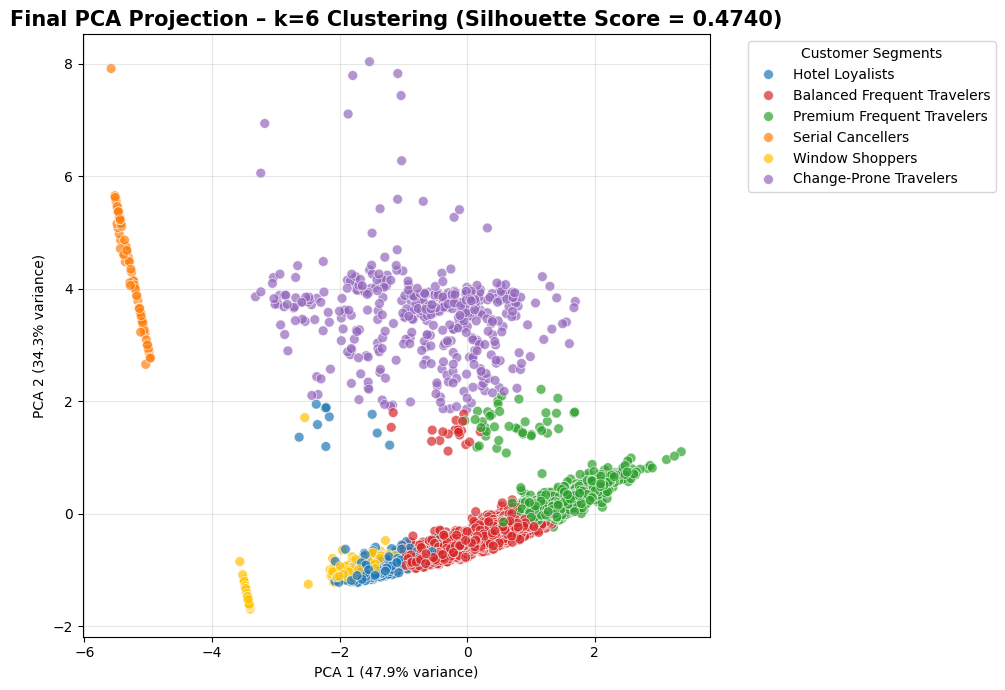

In [23]:
# Map cluster IDs to final names
cluster_names = {
    0: "Premium Frequent Travelers",
    1: "Change-Prone Travelers",
    2: "Window Shoppers",
    3: "Hotel Loyalists",
    4: "Serial Cancellers",
    5: "Balanced Frequent Travelers"
}

# Run PCA to 2 components for plotting
pca_model = PCA(n_components=2, random_state=42)
pca_components = pca_model.fit_transform(df_reduced_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = df['cluster']
pca_df['cluster_name'] = pca_df['cluster'].map(cluster_names)

# Consistent color palette
palette = {
    "Premium Frequent Travelers": "#2ca02c",  # green
    "Change-Prone Travelers": "#9467bd",      # purple
    "Window Shoppers": "#ffc300",             # golden yellow
    "Hotel Loyalists": "#1f77b4",             # blue
    "Serial Cancellers": "#ff7f0e",           # orange
    "Balanced Frequent Travelers": "#d62728"  # red
}


# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PCA1',
    y='PCA2',
    hue='cluster_name',
    palette=palette,
    alpha=0.7,
    s=50
)

plt.title('Final PCA Projection – k=6 Clustering (Silhouette Score = 0.4740)',
          fontsize=15, fontweight='bold')
plt.xlabel(f'PCA 1 ({pca_model.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PCA 2 ({pca_model.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend(title='Customer Segments', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 5.2 Per-Cluster Visuals

In this step, we create visual profiles for each cluster to better understand their behavioral differences.
We will explore:
1. **PCA Zooms** — Highlighting each cluster’s position in the 2-D PCA projection.
2. **Top Distinctive Features** — The 8 features that most differentiate each cluster from the overall user base.
3. **Trip Duration Composition** — How each cluster’s trips break down into short, medium, long, and extended stays.

These visuals provide both a spatial view of how clusters are separated and a metric-level explanation of what makes them unique.


#### 5.2.0 PCA Zoom for Each Cluster

We use the PCA projection from our reduced clustering features to zoom in on one cluster at a time.
- The **highlighted cluster** is shown in its original color from our palette.
- All **other clusters** are shown in light grey for context.
- Axes limits are fixed across plots to keep scale consistent.

This allows us to see where each cluster sits in relation to the others and how tightly grouped it is.


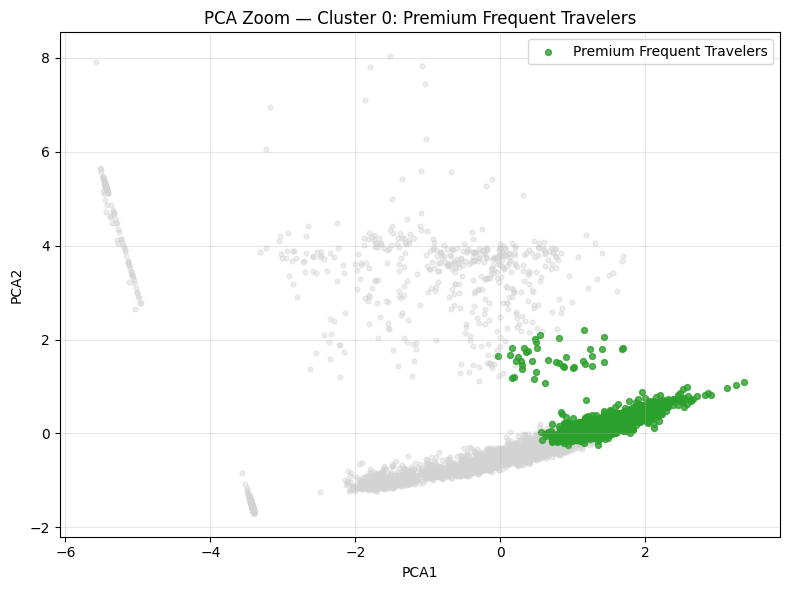

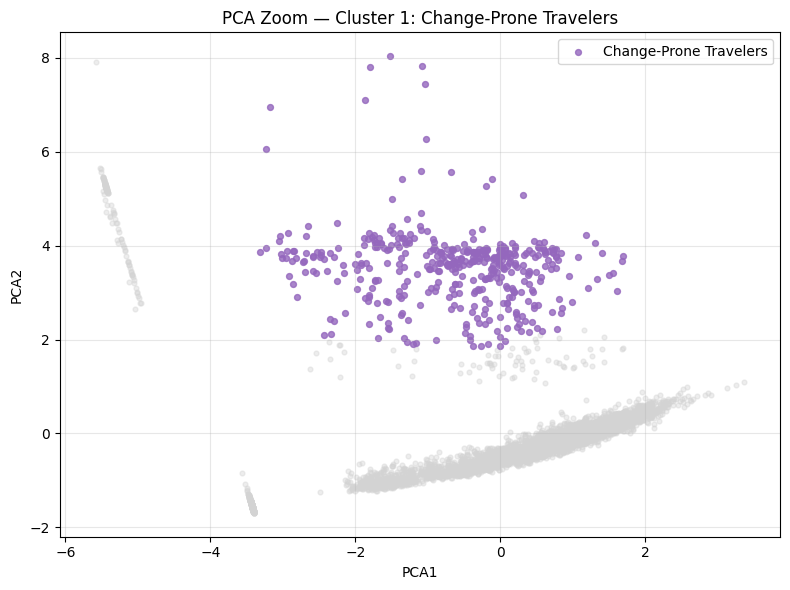

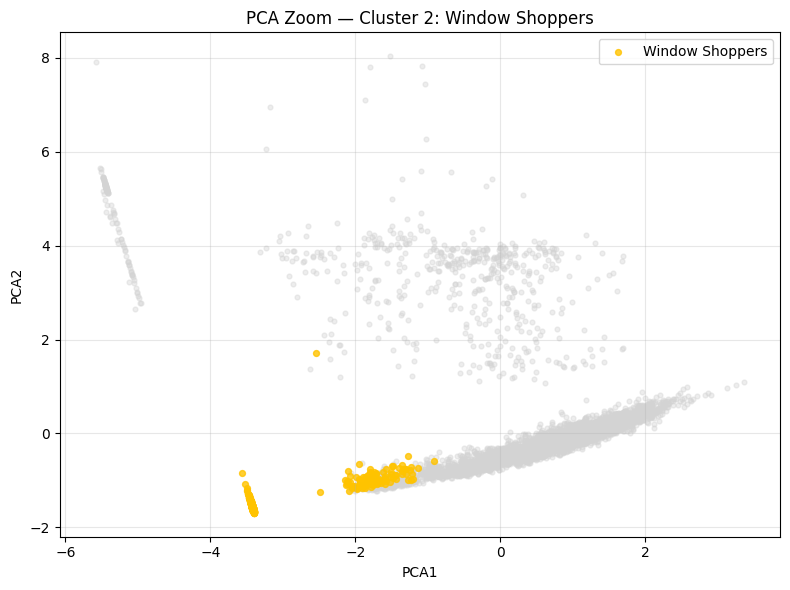

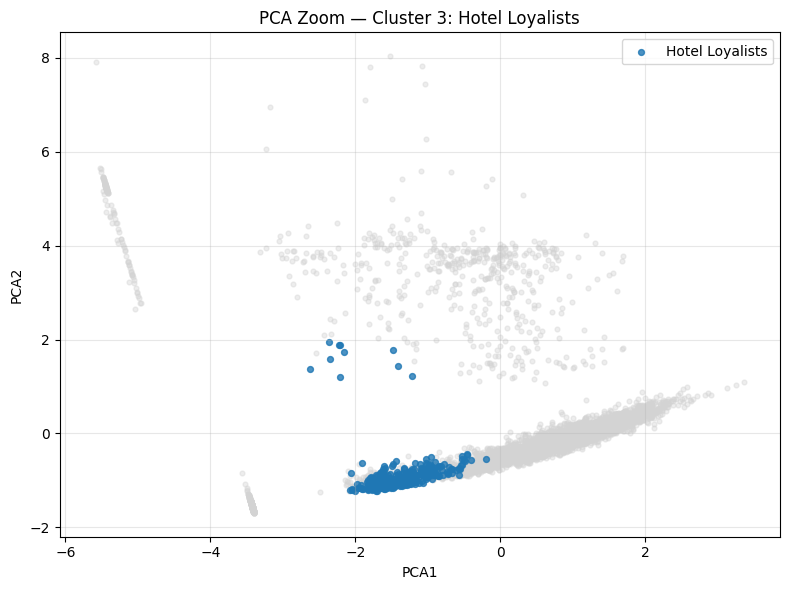

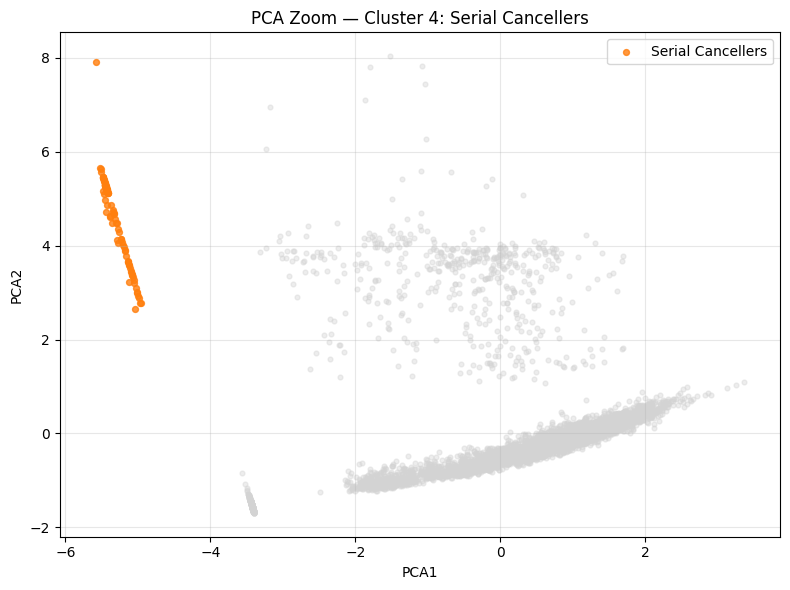

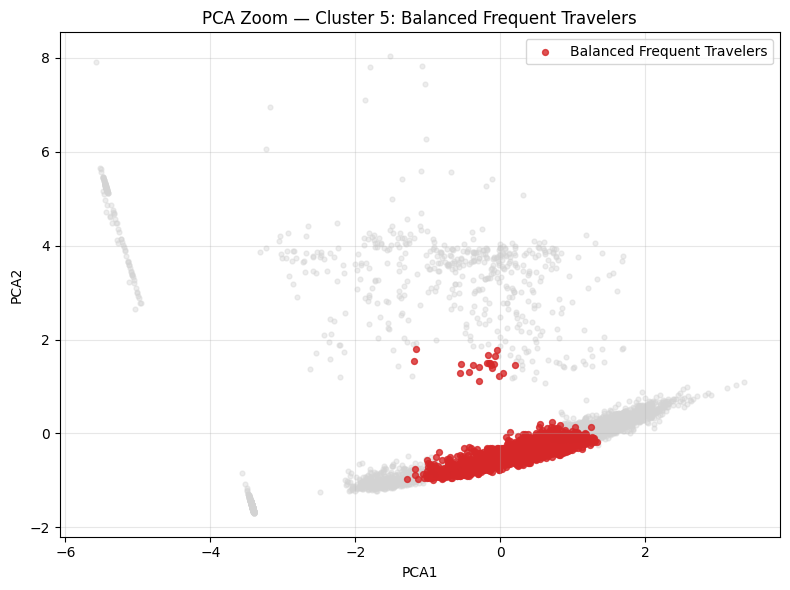

In [24]:
# PCA Zooms per Cluster (highlight target cluster, others grey)

pad = 0.5
x_min, x_max = pca_df['PCA1'].min() - pad, pca_df['PCA1'].max() + pad
y_min, y_max = pca_df['PCA2'].min() - pad, pca_df['PCA2'].max() + pad

for cid in sorted(pca_df['cluster'].unique()):
    cluster_name = pca_df.loc[pca_df['cluster'] == cid, 'cluster_name'].iloc[0]

    plt.figure(figsize=(8,6))

    # Plot all other clusters in grey
    others = pca_df[pca_df['cluster'] != cid]
    plt.scatter(
        others['PCA1'], others['PCA2'],
        color='lightgrey', alpha=0.4, s=12, label='_nolegend_'
    )

    # Plot current cluster in its original color
    current = pca_df[pca_df['cluster'] == cid]
    plt.scatter(
        current['PCA1'], current['PCA2'],
        color=palette[cluster_name], alpha=0.8, s=18, label=cluster_name
    )

    plt.title(f"PCA Zoom — Cluster {cid}: {cluster_name}")
    plt.xlabel("PCA1"); plt.ylabel("PCA2")
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


#### 5.2.1 Top Distinctive Features

For each cluster, we calculate the standardized mean difference (z-score effect) between that cluster and the overall dataset for every available feature.
- We then rank features by **absolute difference** and select the top 8.
- Positive values indicate the cluster’s average is **higher than the overall average**.
- Negative values indicate the cluster’s average is **lower than the overall average**.

These charts reveal which behavioral metrics most strongly define each cluster, even if some were not used directly in the clustering model.


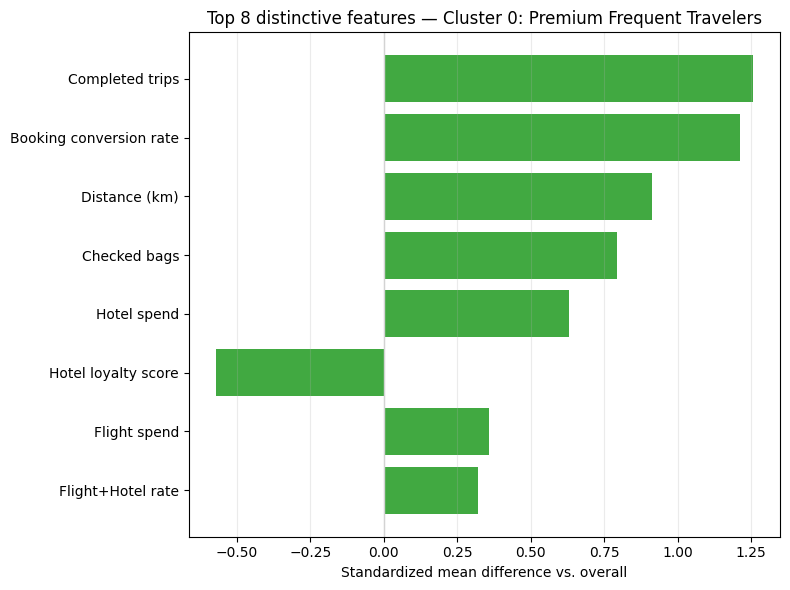

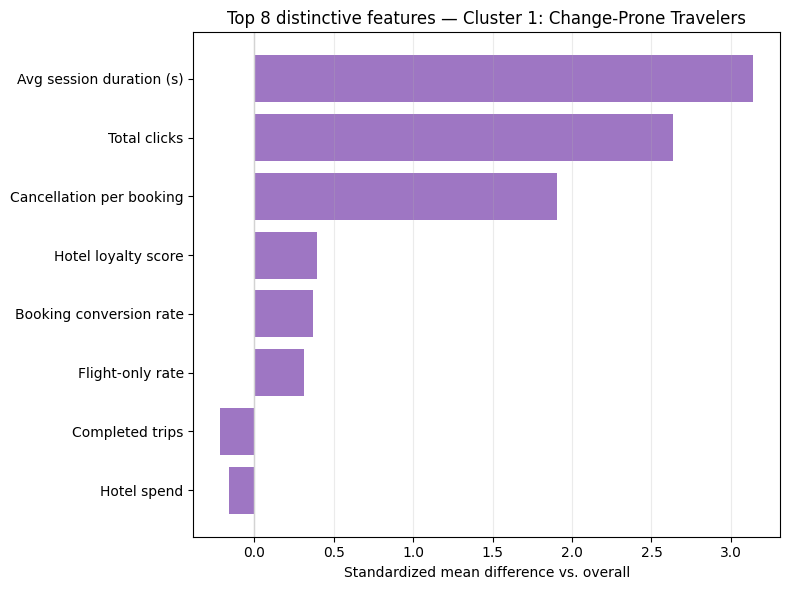

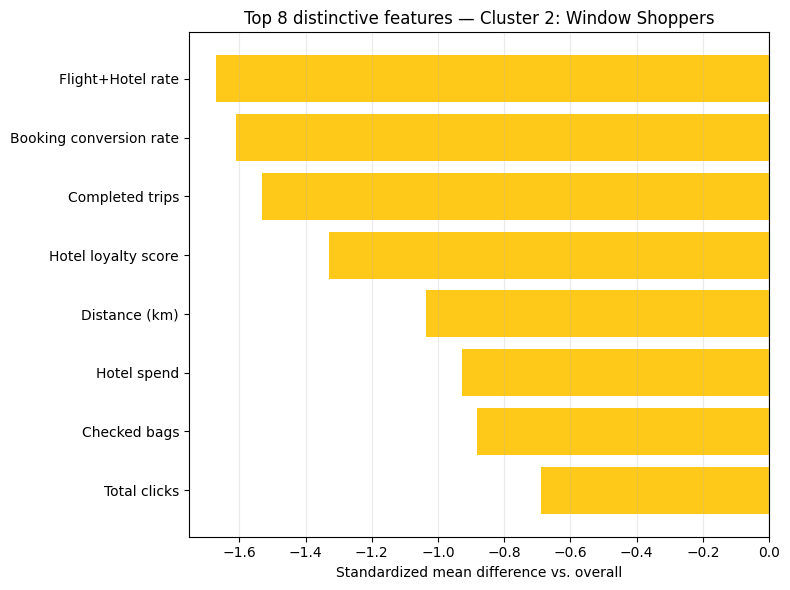

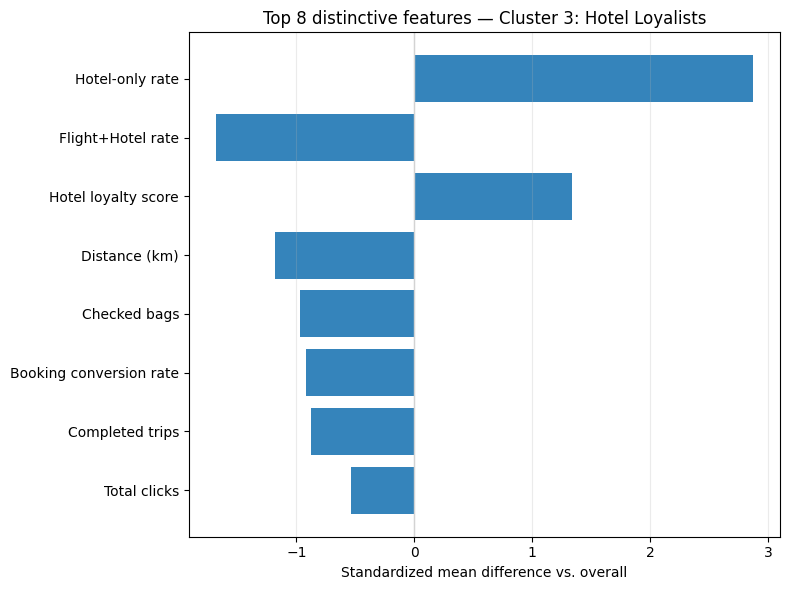

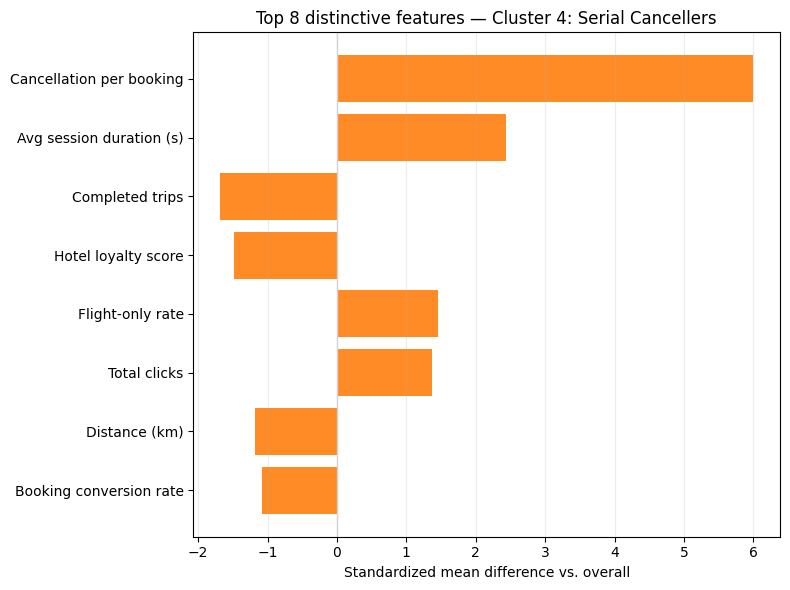

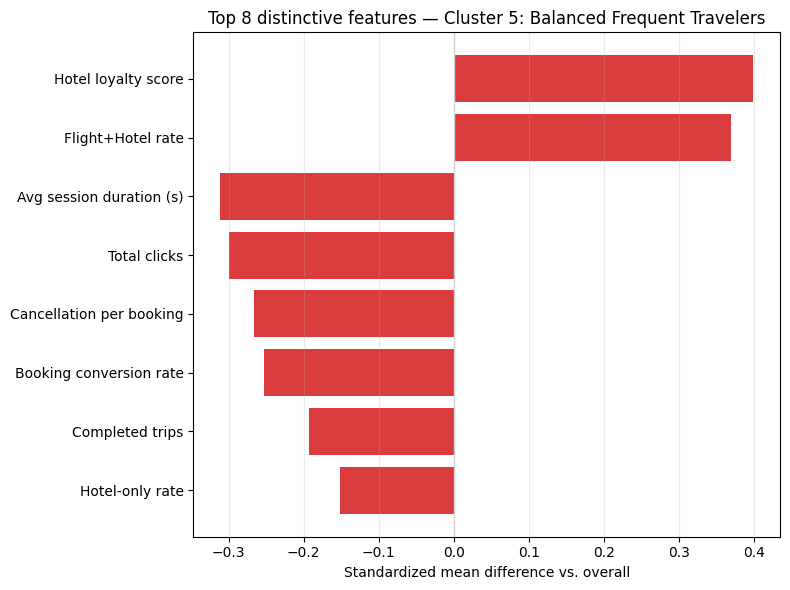

In [25]:
# Use the same features you actually clustered on (readable & stable)
features_to_score = profiling_features  # defined earlier from your code
top_n = 8  # how many distinctive features to show per cluster

# Safety: ensure we have no NA in the scoring space
score_df = df[features_to_score + ['cluster']].copy()
score_df = score_df.dropna(subset=features_to_score)

# Global stats
global_mean = score_df[features_to_score].mean()
global_std = score_df[features_to_score].std(ddof=0).replace(0, np.nan)

# Helper to prettify labels a bit
pretty = {
    'avg_session_duration_sec': 'Avg session duration (s)',
    'booking_conversion_rate': 'Booking conversion rate',
    'money_spent_hotel': 'Hotel spend',
    'money_spent_flight': 'Flight spend' ,
    'cancellation_per_booking_rate': 'Cancellation per booking',
    'total_clicks': 'Total clicks',
    'total_completed_trips': 'Completed trips',
    'avg_days_booking_to_trip': 'Days from booking to trip',
    'hotel_loyalty_score': 'Hotel loyalty score',
    'flight_only_rate': 'Flight-only rate',
    'hotel_only_rate': 'Hotel-only rate',
    'both_booked_rate': 'Flight+Hotel rate',
    'total_sessions': 'Total sessions',
    'total_checked_bags': 'Checked bags',
    'total_distance_km': 'Distance (km)',
    'has_children': 'Has children',
}
def nice(col):
    return pretty.get(col, col)

# Compute effect sizes and plot, in cluster ID order (as you requested)
for cid in sorted(score_df['cluster'].unique()):
    cname = cluster_names.get(cid, f'Cluster {cid}')
    ccol = palette.get(cname, '#333333')

    sub = score_df[score_df['cluster'] == cid]
    c_mean = sub[features_to_score].mean()

    # Standardized mean difference vs overall (like Cohen's d, using global std)
    effect = (c_mean - global_mean) / global_std
    effect = effect.replace([np.inf, -np.inf], np.nan).dropna()

    # Top N by absolute magnitude
    top = effect.reindex(effect.abs().sort_values(ascending=False).index).head(top_n)

    # Plot
    plt.figure(figsize=(8, 6))
    y_labels = [nice(c) for c in top.index]
    plt.barh(y_labels, top.values, color=ccol, alpha=0.9)
    plt.axvline(0, color='lightgrey', linewidth=1)
    plt.title(f"Top {top_n} distinctive features — Cluster {cid}: {cname}")
    plt.xlabel("Standardized mean difference vs. overall")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.25)
    plt.tight_layout()
    plt.show()


#### 5.2.2 Trip Duration Composition

We categorize each user’s average trip duration into:
- **Short** (≤ 3 days)
- **Medium** (4–7 days)
- **Long** (> 7 days)
- **No Trip** (-1 placeholder for users with no completed trips)

The stacked bar chart shows the **percentage of users** in each category per cluster.
This helps us see whether certain clusters prefer short breaks, longer vacations, or have many non-bookers.


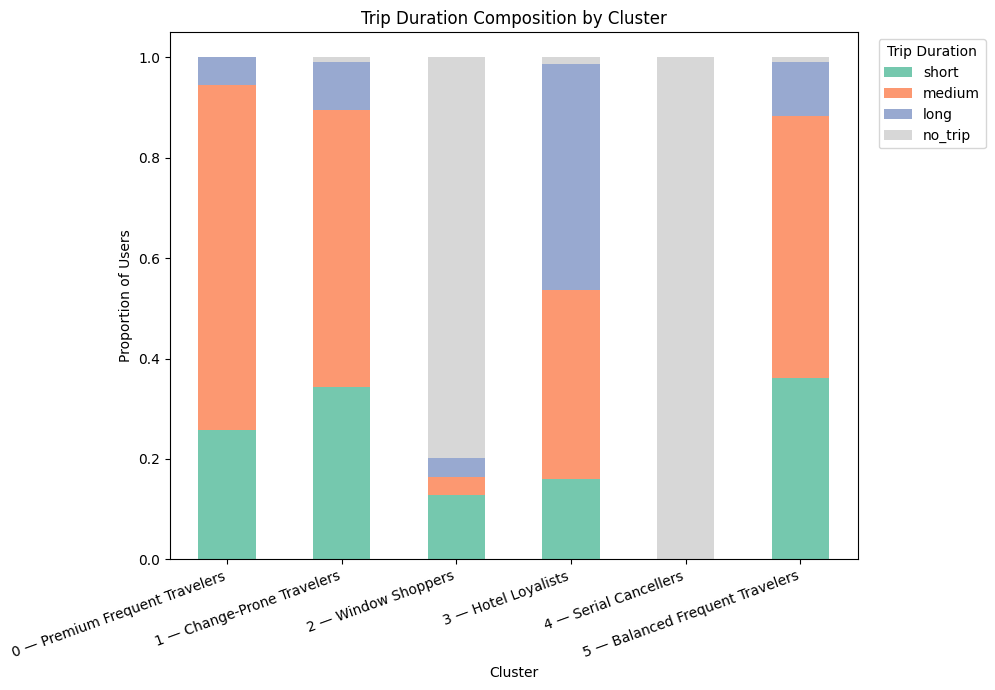

In [26]:
# Calculate proportion per cluster
trip_comp = (
    df.groupby(['cluster', 'trip_duration_type'])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())
      .unstack(fill_value=0)
)

# Ensure consistent order of categories in the stack
duration_order = ['short', 'medium', 'long', 'no_trip']
trip_comp = trip_comp[duration_order]

# Plot
ax = trip_comp.loc[sorted(trip_comp.index)].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 7),
    color=['#66c2a5', '#fc8d62', '#8da0cb', 'lightgrey'],
    alpha=0.9
)
ax.set_title("Trip Duration Composition by Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion of Users")
ax.set_xticklabels(
    [f"{cid} — {cluster_names[cid]}" for cid in sorted(trip_comp.index.get_level_values(0))],
    rotation=20, ha='right'
)

plt.legend(title="Trip Duration", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 5.3 Cross-Cluster Comparisons

In this step, we compare all clusters side by side across key behavioral metrics.  
While Step 20 focused on *within-cluster* profiles, Step 21 highlights *between-cluster* differences to spot broader patterns and overlaps.

We will include:
1. **Radar Chart** — Normalized comparison of key metrics across all clusters.
2. **Booking Type Breakdown** — Average share of flight-only, hotel-only, and combined bookings for each cluster.
3. **Cancellation Rate Bar Chart** — Mean cancellation-per-booking rate by cluster.

These views help identify which clusters behave similarly, where they differ most, and potential areas for perk targeting or operational adjustments.


#### 5.3.0 Radar Chart for Normalized Metrics

We use a radar chart to compare clusters across a focused set of **high-impact behavioral metrics**:

- **avg_session_duration_sec** — Engagement level during sessions.
- **log_money_spent_flight** — Flight spending (log-transformed to reduce skew).
- **log_money_spent_hotel** — Hotel spending (log-transformed to reduce skew).
- **hotel_loyalty_score** — Loyalty to specific hotel brands.
- **booking_conversion_rate** — Efficiency in converting visits to bookings.
- **total_completed_trips** — Overall travel frequency.
- **cancellation_per_booking_rate** — Tendency to cancel after booking.

All metrics are **Min–Max scaled** to [0,1] for comparability.  
Each cluster is shown in its original palette color, with overlapping lines revealing similarities or stark differences.

This visualization provides a side-by-side profile of clusters, making it easier to see which groups lead or lag in each behavioral dimension.


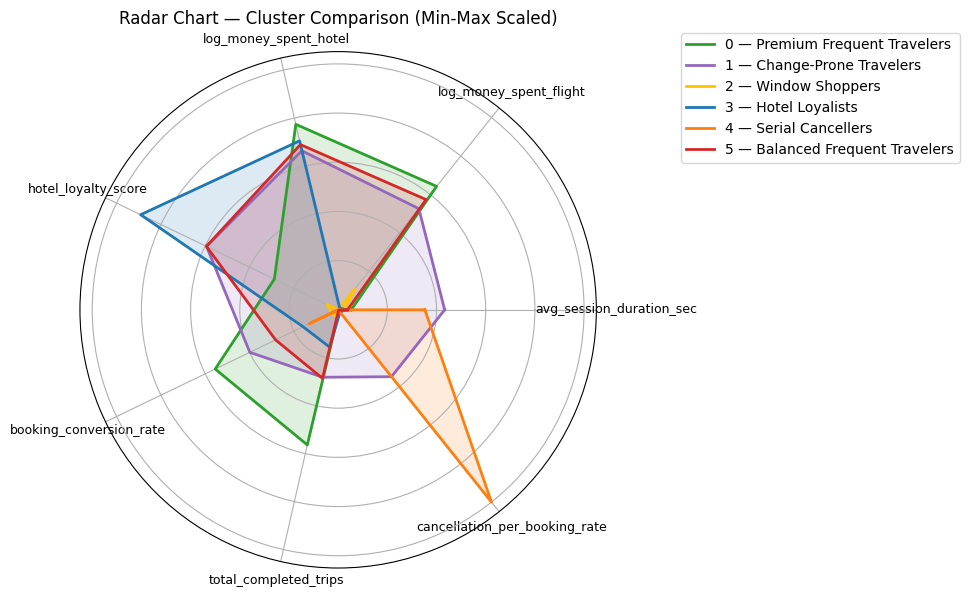

In [27]:
# Step 21.1 — Radar Chart for Normalized Metrics

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Choose high-signal metrics for radar (readable + compact)
radar_metrics = [
    'avg_session_duration_sec',
    'log_money_spent_flight',
    'log_money_spent_hotel',
    'hotel_loyalty_score',
    'booking_conversion_rate',
    'total_completed_trips',
    'cancellation_per_booking_rate'
]

# Ensure no NaNs
radar_df = df[radar_metrics + ['cluster']].copy().fillna(0)

# Min-Max scale each metric to [0,1] across all users
scaler = MinMaxScaler()
radar_scaled = scaler.fit_transform(radar_df[radar_metrics])
radar_df_scaled = pd.DataFrame(radar_scaled, columns=radar_metrics)
radar_df_scaled['cluster'] = radar_df['cluster'].values

# Compute cluster means (scaled values)
radar_means = radar_df_scaled.groupby('cluster')[radar_metrics].mean().loc[sorted(radar_df['cluster'].unique())]

# Radar plot settings
labels = radar_metrics
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
angles = np.concatenate([angles, [angles[0]]])  # Close loop

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Plot each cluster
for cid in radar_means.index:
    values = radar_means.loc[cid].values
    values = np.concatenate([values, [values[0]]])  # Close loop
    cname = cluster_names.get(cid, f"Cluster {cid}")
    ccol = palette.get(cname, '#333333')
    ax.plot(angles, values, label=f"{cid} — {cname}", color=ccol, linewidth=2)
    ax.fill(angles, values, color=ccol, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=9)
ax.set_yticklabels([])
ax.set_title("Radar Chart — Cluster Comparison (Min-Max Scaled)", pad=20)
ax.legend(bbox_to_anchor=(1.15, 1.05), loc='upper left')
plt.tight_layout()
plt.show()


#### 5.3.1 Booking Breakdown with Cancellation Rate

In this combined view, we compare **how each cluster books** versus **how often they cancel**.

- **Left bar (stacked)** → Share of booking types per cluster:  
  - **Flight Only** (blue)  
  - **Hotel Only** (green)  
  - **Both Booked** (orange)  
  - **No Booking** (grey) — added so each bar sums to 100%  

- **Right bar (solid crimson)** → **Cancellation per booking rate** for the same cluster.

By showing these side by side, we can quickly see:
- Which booking types dominate in each cluster  
- How booking patterns relate to cancellation behavior  
- Where high cancellation rates might be linked to certain booking preferences  

This dual-axis layout allows direct comparison while keeping category colors consistent with the rest of the notebook.


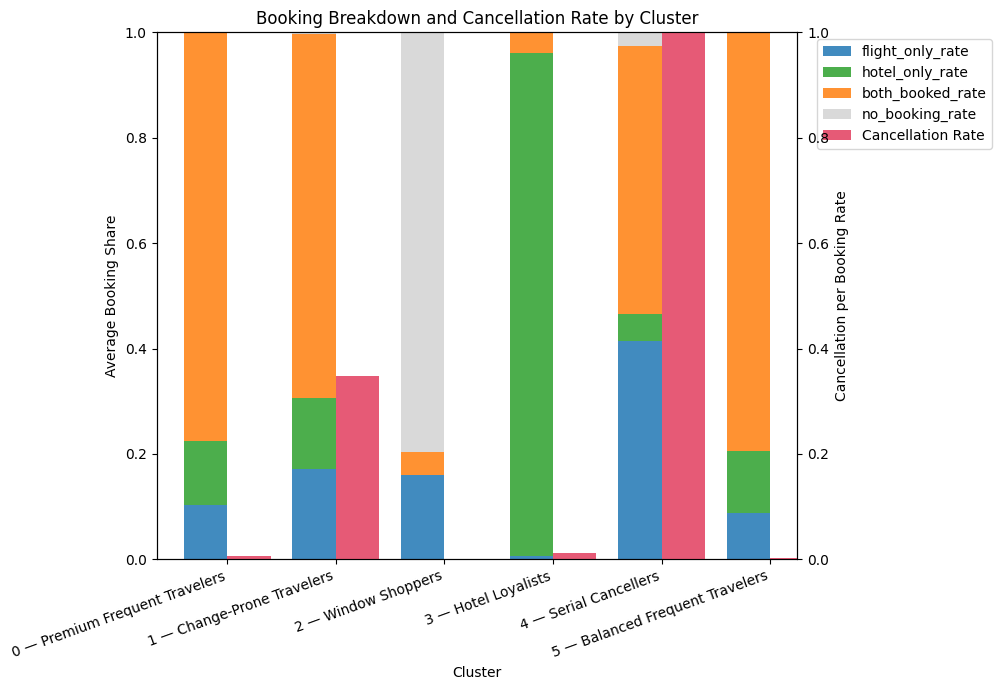

In [28]:
# Step 21.2 + 21.3 — Combined Booking Breakdown & Cancellation Rate

booking_types = ['flight_only_rate', 'hotel_only_rate', 'both_booked_rate']

# Calculate cluster averages for booking types
booking_avg = (
    df.groupby('cluster')[booking_types]
      .mean()
      .loc[sorted(df['cluster'].unique())]
)

# Add no_booking_rate so each bar sums to 1.0
booking_avg['no_booking_rate'] = 1 - booking_avg.sum(axis=1)

# Cancellation rate per cluster
cancel_avg = (
    df.groupby('cluster')['cancellation_per_booking_rate']
      .mean()
      .loc[sorted(df['cluster'].unique())]
)

# Set up plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# Left axis — booking breakdown (stacked bars)
booking_avg[['flight_only_rate', 'hotel_only_rate', 'both_booked_rate', 'no_booking_rate']].plot(
    kind='bar',
    stacked=True,
    color=['#1f77b4', '#2ca02c', '#ff7f0e', 'lightgrey'],
    alpha=0.85,
    ax=ax1,
    width=0.4,
    position=1
)

ax1.set_ylabel("Average Booking Share")
ax1.set_xlabel("Cluster")
ax1.set_ylim(0, 1)

# Right axis — cancellation rate
ax2 = ax1.twinx()
ax2.bar(
    [i + 0.2 for i in range(len(cancel_avg))],
    cancel_avg.values,
    width=0.4,
    color='crimson',
    alpha=0.7,
    label='Cancellation Rate'
)
ax2.set_ylabel("Cancellation per Booking Rate")
ax2.set_ylim(0, 1)

# X-axis labels
ax1.set_xticks(range(len(booking_avg.index)))
ax1.set_xticklabels(
    [f"{cid} — {cluster_names[cid]}" for cid in booking_avg.index],
    rotation=20, ha='right'
)

# Legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.title("Booking Breakdown and Cancellation Rate by Cluster")
plt.tight_layout()
plt.show()


### 5.4 Summary & Next Steps

### **Project at a Glance**
- **Dataset:** ~5998 active TravelTide users (filtered to >7 sessions, Jan–Jul 2023)  
- **Features:** 20 engineered behavioral metrics covering engagement, booking habits, trip patterns, spending,demographic and loyalty  
- **Model:** KMeans (`k=6`) — chosen after testing KMeans, GMM, and feature variants  
- **Silhouette Score:** 0.4740 (strong separation for real-world behavioral data)  
- **Iterations:** Dozens of model runs testing different feature sets, scaling methods, log transforms, and clustering algorithms

---

### **Summary of Process**
Our journey from raw data to actionable clusters was highly iterative.  
We ran **countless experiments** — testing different clustering models (KMeans, GMM, DBSCAN), multiple feature sets, varied scaling approaches, and transformations (log, min–max, standard, robust).  
We assessed silhouette scores, visual separability in PCA space, and business interpretability at each stage before locking in the final solution.

1. **Data Preparation & Feature Engineering**  
   - Aggregated raw session-, trip-, flight-, and hotel-level data into user-level metrics.(Handled by SQL Query)
   - Engineered behavioral features across engagement, booking habits, trip characteristics, spending, and loyalty.  (Handled by SQL Query)
   - Applied log transforms to highly skewed monetary variables, filled missing values with behaviorally consistent defaults, and standardized for clustering.  
   - Iteratively removed low-impact features to focus on variables with stronger behavioral spread.

2. **Dimensionality Reduction & Clustering**  
   - Used PCA for visualization and variance checks.  
   - Tested multiple `k` values and different model types; final model chosen was **KMeans with k=6**, balancing silhouette score (0.4740) with interpretability.  
   - Assigned descriptive names to clusters based on dominant behaviors.

3. **Analysis & Visualization**  
   - Built per-cluster PCA zooms, ranked top distinctive features, and analyzed trip duration distributions.  
   - Compared clusters through radar charts, booking type breakdowns, and combined booking–cancellation visuals.

### **Key Insights**
- The **six clusters** are well-separated in PCA space, each representing distinct engagement, spending, and travel patterns.  
- **Demografic features** emerged as one of the most uniform metrics across clusters.  
- Booking preferences differ sharply: some clusters are hotel-loyal, others balanced, and others have cancellation activity.  
- Trip duration behavior varies widely, from frequent short trips to extended stays.  
- Cancellation rates are concentrated in specific clusters, suggesting varying commitment levels to bookings.


### **Final Perk Assignment**

| Cluster | Segment Name                | Size (% Users) | Final Perk                             |
| ------- | --------------------------- | -------------- | -------------------------------------- |
| **0**   | Premium Frequent Travelers  | 26.87%         | 🏨 1 Free Hotel Night with Flight      |
| **1**   | Change-Prone Travelers      | 7.05%          | ✅ Free Cancellation                    |
| **2**   | Window Shoppers             | 9.55%          | 💰 First-Booking Discount              |
| **3**   | Hotel Loyalists             | 6.25%          | 🏨 Extended Stay Discounts             |
| **4**   | Serial Cancellers           | 1.67%          | 💰 Travel or Credit Offer              |
| **5**   | Balanced Frequent Travelers | 48.61%         | 💼 Free Checked Bag + 🏨 Hotel Upgrade |

### **Data Suitability for Unsupervised Clustering**
- **Strengths:**  
  - Diverse set of engineered behavioral features.  
  - Good cluster separation for selected features in PCA space.  
  - Strong alignment between numerical separation and business interpretability.  
- **Limitations:**  
  - Some metrics (e.g. married, has children, total sessions after >7, discount usage) offered little variance.  
  - Sparse behavior in low-activity users can weaken separation in certain clusters.
  - The original source dataset needs improvements — for example, the *nights* column was incorrectly calculated, and columns such as flight_discount, hotel_discount, flight_booked, and hotel_booked were set to TRUE for every cancellation session regardless of their original booking state.

### **Next Steps**
1. **Finalize Cluster Profiles** — Produce concise, business-friendly descriptions of each segment.  
2. **Perk Mapping** — Align perks to behaviors (e.g., loyalty rewards for hotel-focused clusters, flexible booking perks for high-cancellation clusters).  
3. **Integration into Marketing** — Feed cluster labels into CRM to enable targeted campaigns.  
4. **Performance Tracking** — Monitor KPIs like booking frequency, retention, and perk redemption.  
5. **Loyalty Tiering** — Develop a ranked system (e.g., Gold, Silver, Bronze) based on completed trips and money spent to incentivize high-value customers.  
6. **Ongoing Refinement** — Re-run segmentation periodically as user behavior evolves.
7. **Model Advancement** — If future iterations with more data improve separation (e.g., silhouette score ≥ X), consider training a supervised model to predict cluster membership automatically and assign perks in real time.  


Our work provides a **robust, tested, and interpretable segmentation model** — built on extensive iteration, data-driven feature engineering, and validation — ready for immediate deployment in TravelTide’s personalized rewards strategy.


In [29]:
# === Add cluster_name, and perk columns ===

#  Map cluster names
df['cluster_name'] = df['cluster'].map(cluster_names)

# 3. Map perks
perk_mapping = {
    "Premium Frequent Travelers": "🏨 1 Free Hotel Night with Flight",
    "Change-Prone Travelers": "✅ Free Cancellation",
    "Window Shoppers": "💰 First-Booking Discount",
    "Hotel Loyalists": "🏨 Extended Stay Discounts",
    "Serial Cancellers": "💰 Travel or Credit Offer",
    "Balanced Frequent Travelers": "💼 Free Checked Bag + 🏨 Complimentary Hotel Upgrade"
}
df['perk'] = df['cluster_name'].map(perk_mapping)

# Quick check
df[['user_id', 'cluster', 'cluster_name', 'perk']].head()


,user_id,cluster,cluster_name,perk
0,23557,3,Hotel Loyalists,🏨 Extended Stay Discounts
1,94883,5,Balanced Frequent Travelers,💼 Free Checked Bag + 🏨 Complimentary Hotel Upg...
2,101486,5,Balanced Frequent Travelers,💼 Free Checked Bag + 🏨 Complimentary Hotel Upg...
3,101961,0,Premium Frequent Travelers,🏨 1 Free Hotel Night with Flight
4,106907,4,Serial Cancellers,💰 Travel or Credit Offer


### 5.5 Export Final CSV Files

In this step, we export the key datasets used and produced during the project for documentation, reproducibility, and future analysis.

**1) `TravelTideFinalCompleted.csv`**  
**Source:** `df_completed = df` **+** `['cluster', 'cluster_name', 'perk']`  
**Use:** Full, enriched user-level dataset with final cluster and perk assignments.

**2) `TravelTideUserPerk.csv`**  
**Source:** `df_user_perk = ['user_id', 'cluster', 'cluster_name', 'perk']`  
**Use:** Compact lookup table for activation and downstream integrations.

**3) `TravelTideLogCols.csv`**  
**Source:** `df_log_cols = ['log_money_spent_flight', 'log_money_spent_hotel', 'log_avg_days_booking_to_trip']`  
**Use:** Logged features used in experimentation and diagnostics.

**4) `TravelTideScaled.csv`**  
**Source:** `df_scaled = df_final_scaled`  
**Use:** Scaled feature matrix (full selected features) used for clustering.

**5) `TravelTideReducedScaled.csv`**  
**Source:** `df_reduced_scaled`  
**Use:** Scaled matrix of the **reduced feature set** (post feature drop), used for the refined clustering runs and visuals.

_All files are saved as `.csv` for easy sharing and reuse._


In [31]:
# 1) Completed dataset: original df already includes cluster fields
df_completed = df[['user_id', 'age', 'married', 'has_children', 'total_sessions',
       'total_clicks', 'avg_session_duration_sec', 'total_completed_trips',
       'booking_conversion_rate', 'total_checked_bags', 'total_distance_km',
       'money_spent_flight', 'money_spent_hotel', 'hotel_loyalty_score',
       'avg_days_booking_to_trip', 'avg_trip_duration_days',
       'trip_duration_type', 'flight_only_rate', 'hotel_only_rate',
       'both_booked_rate', 'discount_usage_rate', 'cancellation_per_booking_rate',
       'cluster','cluster_name', 'perk']].copy()
df_completed.to_csv('TravelTideFinalCompleted.csv', index=False)

# 2) User → Cluster/Perk mapping
df_user_perk = df[['user_id', 'cluster', 'cluster_name', 'perk']].copy()
df_user_perk.to_csv('TravelTideUserPerk.csv', index=False)

# 3) Log-transformed columns only
df_log_cols = df[['log_money_spent_flight', 'log_money_spent_hotel', 'log_avg_days_booking_to_trip']].copy()
df_log_cols.to_csv('TravelTideLogCols.csv', index=False)

# 4) Scaled features from the full selected set
df_scaled = df_final_scaled.copy()
df_scaled.to_csv('TravelTideScaled.csv', index=False)

# 5) Reduced scaled features
if isinstance(df_reduced_scaled, np.ndarray):
    df_reduced_scaled_df = pd.DataFrame(df_reduced_scaled, columns=reduced_features)
else:
    df_reduced_scaled_df = df_reduced_scaled.copy()
df_reduced_scaled_df.to_csv('TravelTideReducedScaled.csv', index=False)

# Trigger downloads (comment out if you prefer files to remain in /content)
#for fn in [
#   'TravelTideFinalCompleted.csv',
#    'TravelTideUserPerk.csv',
#    'TravelTideLogCols.csv',
#    'TravelTideScaled.csv',
#    'TravelTideReducedScaled.csv'
#]:
#    files.download(fn)


Athanasios Kardamis\
Data Analyst\
*August 2025*